# Model Status:
Probabilistic ResNet18: 56% Y1 test accuracy, 57% Y1 test wtd. avg. precision, 47% Y10 test accuracy, 57% Y10 test wtd. avg. precision, 

Probabilistic ResNet18 after trainable TL: 62% Y10 test accuracy, 66% Y10 test wtd. avg. precision, 39% Y1 test accuracy, 49% Y1 test wtd. avg. precision

Probabilistic ResNet18 after non-trainable TL: 54% Y10 test accuracy, 53% Y10 test wtd. avg. precision, 46% Y1 test accuracy, 58% Y1 test wtd. avg. precision

# Load Data and Import Packages

In [37]:
# Import user-defined functions
from preprocessing import *
from training import *

import os, sys
import datetime
import math
import random
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

# arrays
import numpy as np
np.set_printoptions(edgeitems=25, linewidth=100000)
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10000000
from numpy import arcsinh as arcsinh

# ML
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
# data augmentation
# from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, ReLU
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import (Callback, ModelCheckpoint, EarlyStopping, 
                                        ReduceLROnPlateau, LambdaCallback, LearningRateScheduler)
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, ZeroPadding2D, ReLU,
                                     AveragePooling2D, Add, Conv2D, MaxPool2D, BatchNormalization, 
                                     Input, Flatten, Dense, Dropout)
from tensorflow.keras.initializers import VarianceScaling, RandomUniform, HeNormal

# tensorflow add-ons
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import CyclicalLearningRate, AdamW, ExponentialCyclicalLearningRate

# tensorflow probability
import tensorflow_probability as tfp
tfd = tfp.distributions
# Load the TensorBoard notebook extension
%load_ext tensorboard

# pytorch
import torch, torchvision
torch.set_default_dtype(torch.float64) #keep more precision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import models
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import keras_tuner as kt

# sklearn metrics and plotting
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score, 
                             accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, confusion_matrix)

## Plotting
import visualkeras
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import ImageFont
import scipy.stats
import matplotlib.pylab
from matplotlib.patches import Ellipse
import wandb
#from tensorflow.keras.utils import plot_model
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("PyTorch version: ", torch.__version__)
print('Using device:', device)
print("Python version: ", sys.version)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.10.0
Num GPUs Available:  1
PyTorch version:  1.13.1.post200
Using device: cuda
Python version:  3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:45:29) 
[GCC 10.4.0]


In [38]:
# Fix seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

In [39]:
# Load year 1 train, test, validation image files (noisy)
X_train_1 = np.load('/deepskieslab/mdunn/images_Y1_train.npy')
X_test_1 = np.load('/deepskieslab/mdunn/images_Y1_test.npy')
X_valid_1 = np.load('/deepskieslab/mdunn/images_Y1_valid.npy')

In [40]:
# Load year 10 train, test, validation image files (pristine)
X_train_10 = np.load('/deepskieslab/mdunn/images_Y10_train.npy')
X_test_10 = np.load('/deepskieslab/mdunn/images_Y10_test.npy')
X_valid_10 = np.load('/deepskieslab/mdunn/images_Y10_valid.npy')

In [41]:
# Load image label files
Y_train = np.load('/deepskieslab/mdunn/labels_train.npy')
Y_test = np.load('/deepskieslab/mdunn/labels_test.npy')
Y_valid = np.load('/deepskieslab/mdunn/labels_valid.npy')

# Pre-process & Verify Data

In [11]:
print( "Data dimensions: ")
# same for years 10 and 1
print("Training Set:", np.shape(X_train_1)) 
print("Test Set:", np.shape(X_test_1))
print("Validation Set:", np.shape(X_valid_1))
print("Training Labels:", np.shape(Y_train))
print("Test Labels:", np.shape(Y_test))
print("Validation Labels:", np.shape(Y_valid))

Data dimensions: 
Training Set: (23487, 3, 100, 100)
Test Set: (6715, 3, 100, 100)
Validation Set: (3355, 3, 100, 100)
Training Labels: (23487, 3)
Test Labels: (6715, 3)
Validation Labels: (3355, 3)


In [42]:
# 3 Classes
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)

In [43]:
# Dataset is imbalanced, so want to use class weights
class_weights = generate_class_weights(Y_train) # use for training

# See class weights for each set
print('Training class weights:', generate_class_weights(Y_train))
print('Test class weights:', generate_class_weights(Y_test))
print('Validation class weights:', generate_class_weights(Y_valid))

Training class weights: {0: 0.7815713287411401, 1: 1.372304995617879, 2: 1.0082421120412106}
Test class weights: {0: 0.7818139480731168, 1: 1.3723686899652565, 2: 1.0078042923607984}
Validation class weights: {0: 0.7809590316573557, 1: 1.3721881390593047, 2: 1.0093261131167268}


In [8]:
# check data sizes
NUM_TRAIN = 23487
NUM_TEST = 6715
NUM_VALIDATION = 3355
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_1) + len(X_test_1) + len(X_valid_1), "total\
training, test, validation samples not equal to total samples - exiting"

33557


In [44]:
### Normalize Pixel Values, Apply sinh
# clip outliers, apply arcsinh to Y1
update_sinh(X_train_1)
update_sinh(X_test_1)
update_sinh(X_valid_1)

# clip outliers, apply arcsinh to Y10
update_sinh(X_train_10)
update_sinh(X_test_10)
update_sinh(X_valid_10)

# Fully Probabilistic Bayesian Neural Network

In [45]:
tf.config.run_functions_eagerly(True)

# Negative log-likelihood loss function
@tf.function
def nll(y_true, y_pred):
  """
  Function should return the negative log-likelihood of each sample
  in y_true given the predicted distribution y_pred.
  """
  return -tf.reduce_mean(y_pred.log_prob(y_true))

#### Functions for evaluating, visualizing predictions

In [15]:
# random test prediction examples
examples = [0, 1500, 2500, # spiral galaxies
            3800, 4000, 4200, # galaxy mergers
            5900, 6000, 6200 # elliptical galaxies
           ]

In [19]:
def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    NUM_CLASSES = 3
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num]
    predicted_probabilities = np.empty(shape=(ensemble_size, NUM_CLASSES))
    
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).numpy().mean()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[...][0])
    ax1.axis('off')
    if true_label[0] == 1:
        ax1.set_title('True label: Spiral')
    elif true_label[1] == 1:
        ax1.set_title('True label: Elliptical')
    elif true_label[2] == 1:
        ax1.set_title('True label: Merger')
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(NUM_CLASSES)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(NUM_CLASSES)])     
    bar = ax2.bar(np.arange(NUM_CLASSES), color='red')
    if true_label[0] == 1:
        bar[0].set_color('green')
    elif true_label[1] == 1:
        bar[1].set_color('green')
    elif true_label[2] == 1:
        bar[2].set_color('green')
    ax2.bar(np.arange(NUM_CLASSES), color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(NUM_CLASSES))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Example Model Estimated Probabilities')
    plt.savefig(f'{str(model)}_estimated_probabilities_examples.png')
    plt.show()

## Probabilistic CNN

#### Setup

In [29]:
# Define probabilistic CNN model using ResNet18 architecture
def conv3x3(x, out_planes, stride=1):
    x = ZeroPadding2D(padding=1)(x)
    return Conv2D(filters=out_planes, kernel_size=3, strides=stride)(x)

# Residual block
def basic_block(x, planes, stride=1, downsample=None):
    # Original input
    identity = x

    # First convolutional layer per block
    out = conv3x3(x, planes, stride=stride)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    # Second convolutional layer per block
    out = conv3x3(out, planes)
    out = BatchNormalization()(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = tf.keras.layers.add([identity, out])
    out = Activation('relu')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    # Do downsample if stride not 1
    if stride != 1 or inplanes != planes:
        # Use kernel size 1, stride 2 for convolutional layers in residual blocks 2 and after
        downsample = [
            Conv2D(filters=planes, kernel_size=1, strides=stride),
            BatchNormalization(),
        ]
    # Create residual block; blocks 2 and after will have downsample
    x = basic_block(x, planes, stride, downsample)
    
    # Create 2 residual blocks per module
    for i in range(1, blocks):
        x = basic_block(x, planes)

    return x

def resnet18_prob(x, num_classes=NUM_CLASSES):
    # First convolutional layer is 7x7 with 64 output channels and stride 2, then Max-pooling layer with stride 2
    x = ZeroPadding2D(padding=3)(x)
    x = Conv2D(filters=64, kernel_size=7, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=1)(x)
    x = MaxPool2D(pool_size=3, strides=2)(x)

    # ResNet18 uses two residual blocks for each module (filter size) here, 4 convolutional layers per module
    # First 2 blocks use stride 1
    x = make_layer(x, 64, 2)
    # All layers after this use stride 2
    x = make_layer(x, 128, 2, stride=2)
    x = make_layer(x, 256, 2, stride=2)
    x = make_layer(x, 512, 2, stride=2)

    # Final layers
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    distribution_params = Dense(tfp.layers.OneHotCategorical.params_size(num_classes), activation='relu')(x)
    outputs = tfp.layers.OneHotCategorical(num_classes, 
                                           convert_to_tensor_fn=tfp.distributions.Distribution.mode)(distribution_params)

    return outputs

In [35]:
def model_builder(hp):
    # Initialize probabilistic model
    inputs = Input(shape = (3, 100, 100))
    outputs = resnet18_prob(inputs)
    model = Model(inputs, outputs)

    ## Compile Model
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4, 
                                         1e-5, 1e-6, 1e-7])
    optimizer = Adam(lr=hp_learning_rate)
    model.compile(optimizer=optimizer, loss=nll, metrics=['accuracy'])
    model.summary()
    return model

# instantiate the Hyperband tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     seed=0,
                     max_epochs=200)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


#### Train

In [36]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "Prob ResNet18"

es = [EarlyStopping(monitor='val_loss', mode='min', 
                    verbose=1, patience=5), 
      ModelCheckpoint(filepath='prob_resnet18_best_weights', 
                      monitor='val_accuracy', 
                      mode='max', verbose=1, 
                      save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir)
      ]

In [37]:
batch_size = 16

# Run the hyperparameter search
tuner.search(X_train_1, Y_train, 
             batch_size = batch_size,             
             validation_data = (X_valid_1, Y_valid),
             shuffle = True,
             class_weight = class_weights,
             verbose = 1,
             callbacks = es
            )

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [38]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]

print(f"""
The hyperparameter search is complete. The optimal 
learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal 
learning rate for the optimizer is 1e-06.



In [ ]:
# Find optimal number of epochs to train model with 
# hyperparameters obtained from search

# Build model with optimal hyperparameters and train it
# on data for 100 epochs
resnet18_prob_model = tuner.hypermodel.build(best_hps)

batch_size = 16
NUM_EPOCH = 100
history_prob = resnet18_prob_model.fit(X_train_1, Y_train,
                                        batch_size = batch_size,
                                        epochs = NUM_EPOCH,              
                                        validation_data = (X_valid_1, Y_valid),
                                        shuffle = True,
                                        class_weight = class_weights,
                                        verbose = 1,
                                        callbacks = es
                                        )

val_acc_per_epoch = history_prob.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 9, 106, 100)  0          ['input_2[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 2, 50, 64)    313664      ['zero_padding2d_18[0][0]']      
                                                                                            

INFO:tensorflow:Assets written to: prob_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_best_weights/assets


1468/1468 [==============================] - 153s 104ms/step - loss: 1.2546 - accuracy: 0.4247 - val_loss: 1.0647 - val_accuracy: 0.4447
Epoch 2/100
1468/1468 [==============================] - ETA: 0s - loss: 1.1175 - accuracy: 0.4219
Epoch 2: val_accuracy did not improve from 0.44471
1468/1468 [==============================] - 139s 94ms/step - loss: 1.1175 - accuracy: 0.4219 - val_loss: 1.0323 - val_accuracy: 0.4438
Epoch 3/100
1468/1468 [==============================] - ETA: 0s - loss: 1.0798 - accuracy: 0.4336
Epoch 3: val_accuracy did not improve from 0.44471
1468/1468 [==============================] - 142s 96ms/step - loss: 1.0798 - accuracy: 0.4336 - val_loss: 1.0352 - val_accuracy: 0.4382
Epoch 4/100
1468/1468 [==============================] - ETA: 0s - loss: 1.0664 - accuracy: 0.4370
Epoch 4: val_accuracy did not improve from 0.44471
1468/1468 [==============================] - 141s 96ms/step - loss: 1.0664 - accuracy: 0.4370 - val_loss: 1.0243 - val_accuracy: 0.4379
Epoch

INFO:tensorflow:Assets written to: prob_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_best_weights/assets


1468/1468 [==============================] - 148s 101ms/step - loss: 1.0265 - accuracy: 0.4442 - val_loss: 1.0796 - val_accuracy: 0.4462
Epoch 9/100
 912/1468 [=================>............] - ETA: 50s - loss: 1.0188 - accuracy: 0.4540

In [ ]:
# Re-instantiate hypermodel, train with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)

# re-train model
history_prob = hypermodel.fit(X_train_1, Y_train,
                            batch_size = batch_size,
                            epochs = best_epoch,              
                            validation_data = (X_valid_1, Y_valid),
                            shuffle = True,
                            class_weight = class_weights,
                            verbose = 1,
                            callbacks = es
                            )

# Save Probabilistic model data
hypermodel.save(filepath = f'Y1_ResNet18_Dropout_Probabilistic', 
                         include_optimizer = True, 
                         overwrite = True)

# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout_Probabilistic_history.npy', history_prob.history)

In [ ]:
%tensorboard --logdir logs/fit

In [10]:
# reload model, history if needed
# best model weights loaded into the model
resnet18_prob_model = load_model('prob_resnet18_best_weights', 
                                 compile=False)
history_prob = np.load('Y1_ResNet18_Dropout_Probabilistic_history.npy', 
                       allow_pickle=True).item()

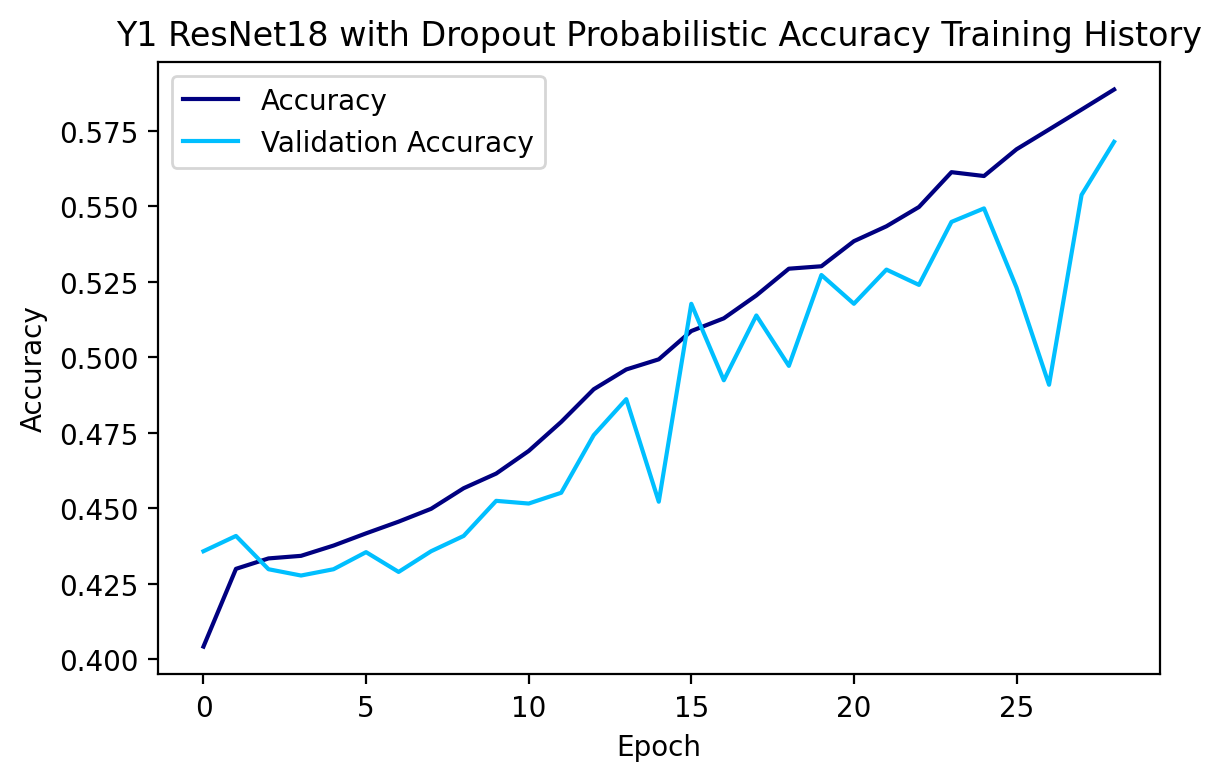

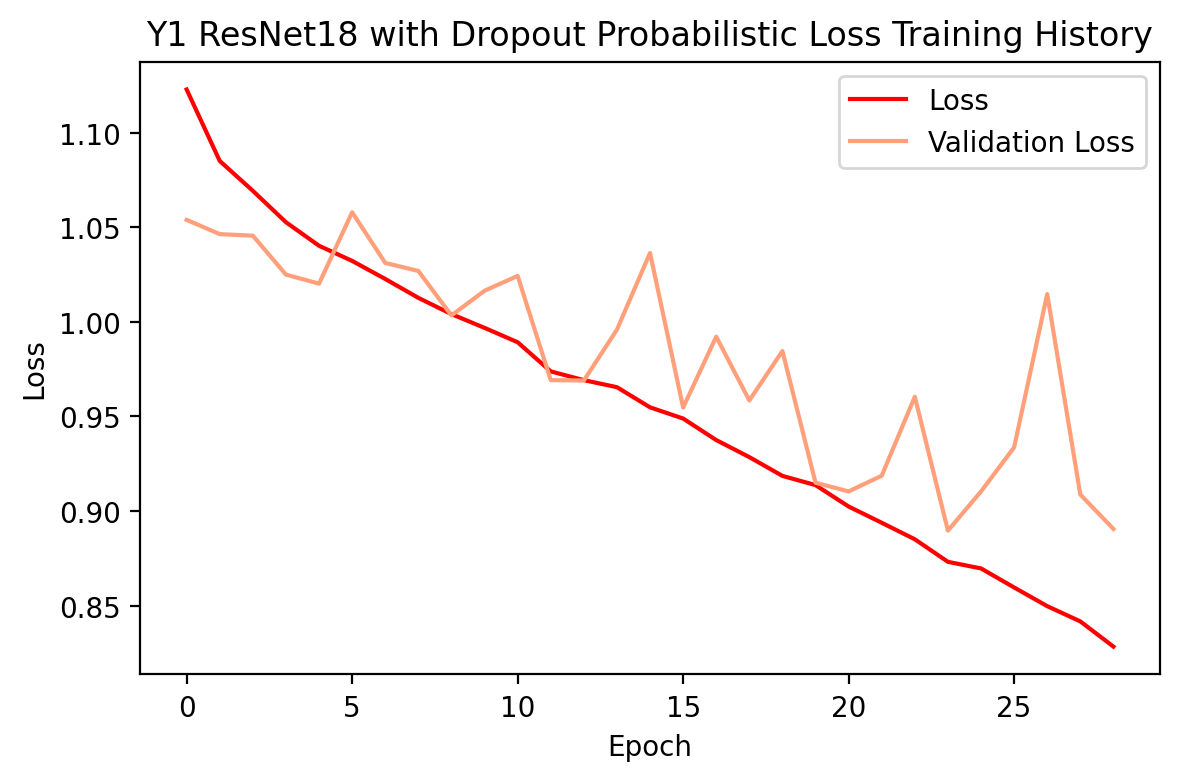

In [11]:
# Plot Probabilistic model training history
acc = history_prob['accuracy']
val_acc = history_prob['val_accuracy']

loss = history_prob['loss']
val_loss = history_prob['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Y1 ResNet18 with Dropout Probabilistic Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout Probabilistic Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Y1 ResNet18 with Dropout Probabilistic Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout Probabilistic Loss Training History")
plt.show()

#### Evaluate on Y1 and Y10 test data

2023-04-27 16:49:54.672031: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-27 16:49:54.984471: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


210/210 [==============================] - 9s 30ms/step
Y1 Test:
              precision    recall  f1-score   support

      Spiral       0.55      0.85      0.67      2863
  Elliptical       0.58      0.22      0.32      1631
      Merger       0.60      0.44      0.51      2221

    accuracy                           0.56      6715
   macro avg       0.58      0.51      0.50      6715
weighted avg       0.57      0.56      0.53      6715


210/210 [==============================] - 6s 29ms/step


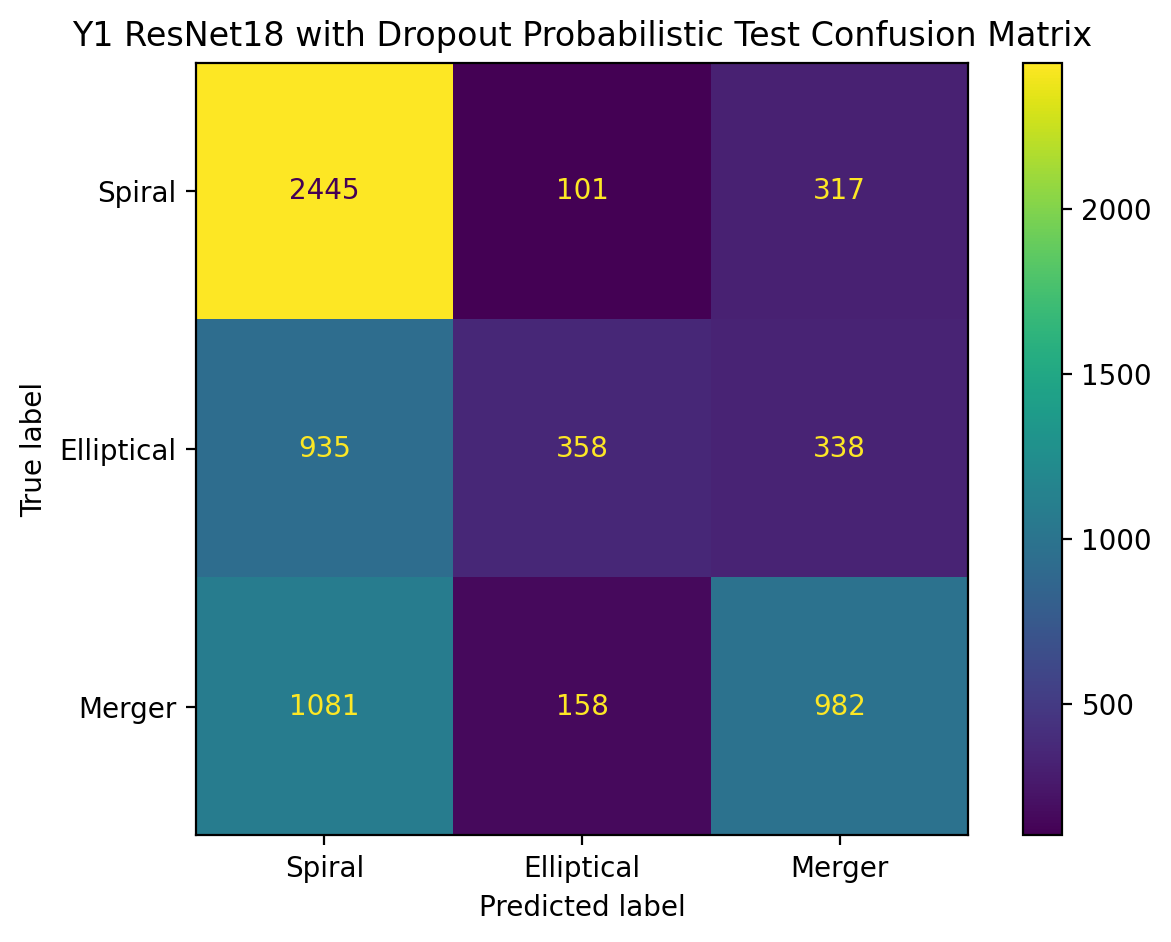

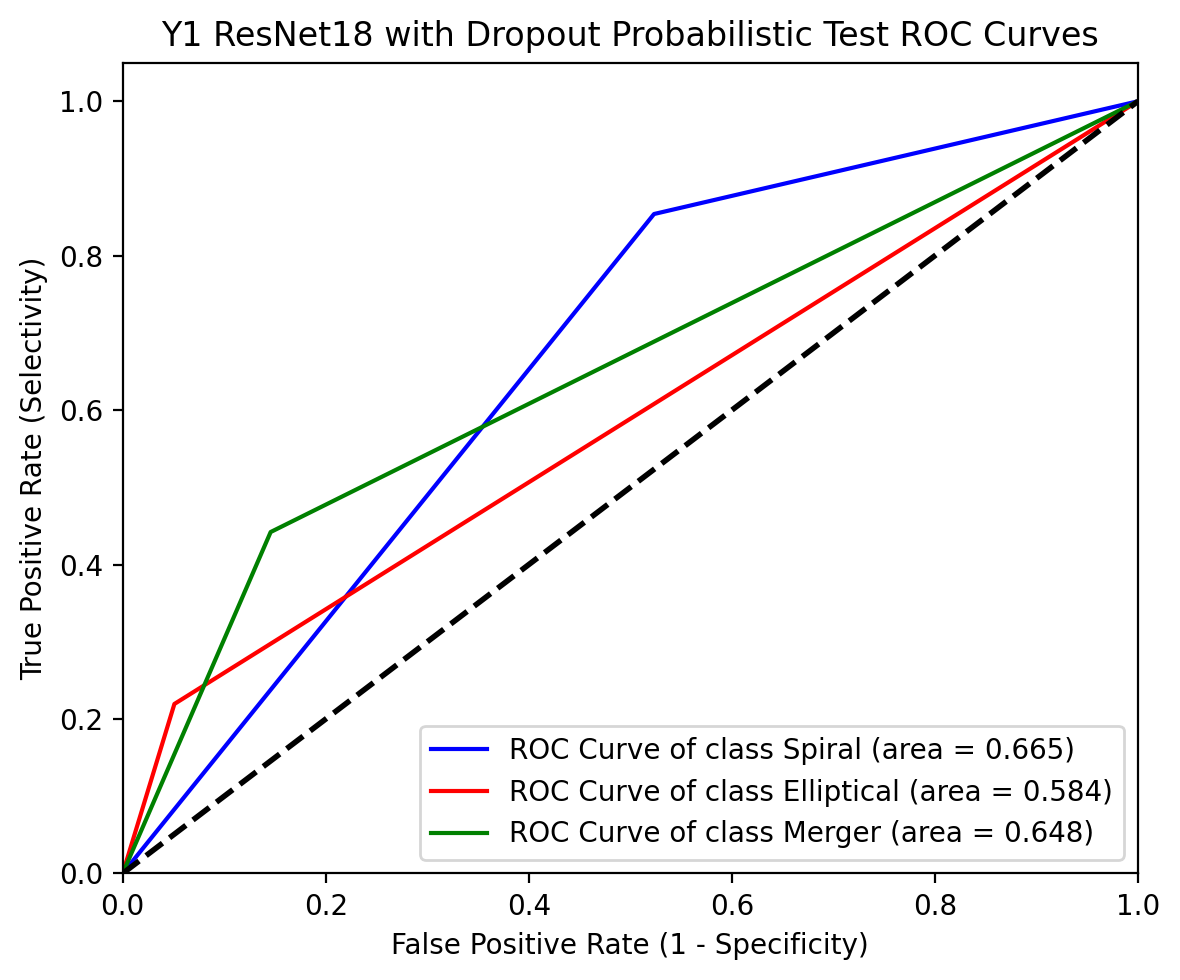

In [12]:
# test on Y1
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_prob_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(resnet18_prob_model.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 with Dropout Probabilistic Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_Y1_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 with Dropout Probabilistic Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_Y1_test_ROC')
plt.show()

210/210 [==============================] - 6s 30ms/step
Y10 Test:
              precision    recall  f1-score   support

      Spiral       0.45      0.98      0.62      2863
  Elliptical       0.59      0.16      0.26      1631
      Merger       0.69      0.03      0.05      2221

    accuracy                           0.47      6715
   macro avg       0.58      0.39      0.31      6715
weighted avg       0.57      0.47      0.34      6715


210/210 [==============================] - 6s 30ms/step


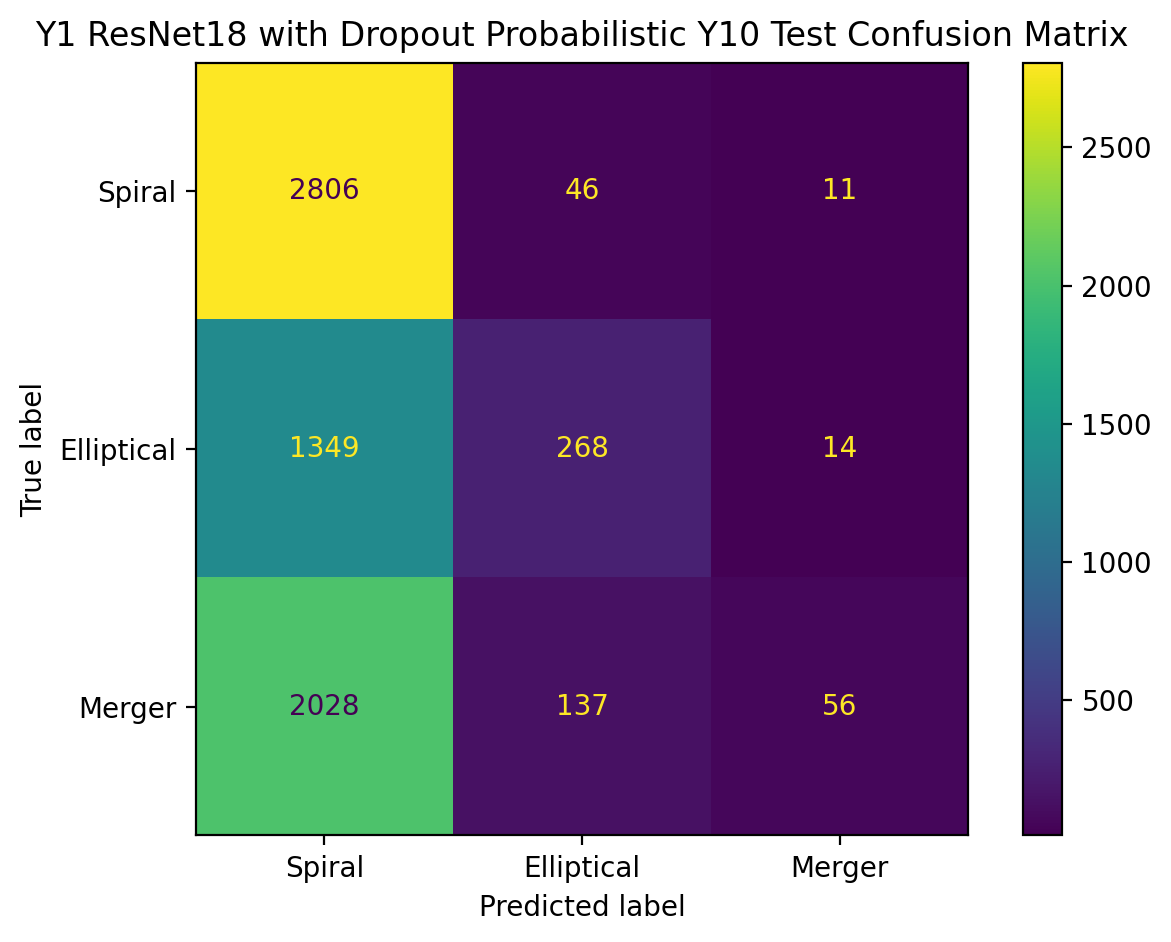

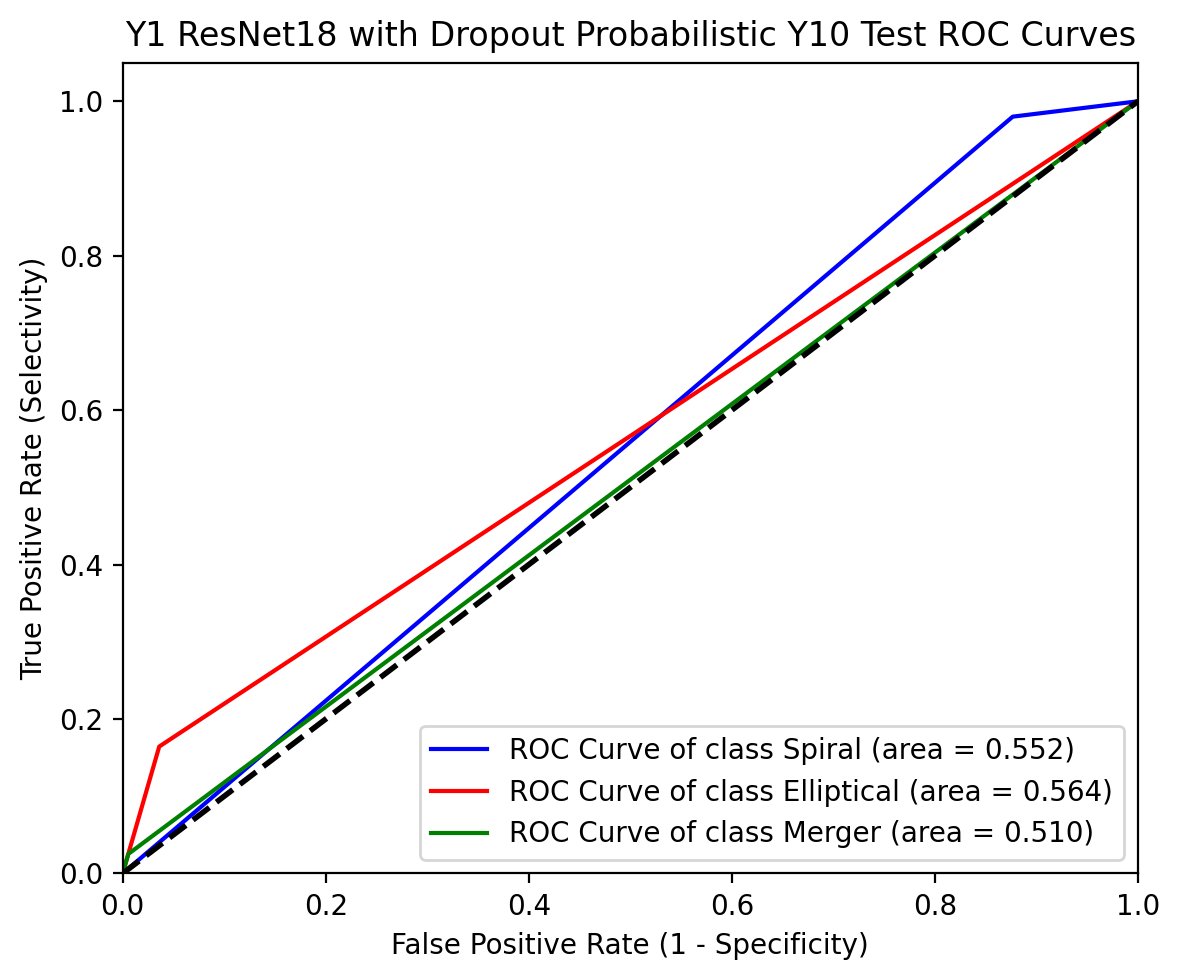

In [13]:
# test on Y10
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_prob_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(resnet18_prob_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 with Dropout Probabilistic Y10 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_Y10_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 with Dropout Probabilistic Y10 Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_Probabilistic_Y10_test_ROC')
plt.show()

### Transfer Learning

#### Method 1: Try TL without making previous layers non-trainable

##### Setup

In [21]:
# Check for trainable and non-trainable variables
print("\n Model has {} trainable variables: {}, ...".format(
          len(resnet18_prob_model.trainable_variables),
          ", ".join([v.name for v in resnet18_prob_model.trainable_variables])))

trainable_variable_ids = {id(v) for v in resnet18_prob_model.trainable_variables}
non_trainable_variables = [v for v in resnet18_prob_model.variables
                           if id(v) not in trainable_variable_ids]
print("\n Model also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables])))


 Model has 82 trainable variables: conv2d_20/kernel:0, conv2d_20/bias:0, batch_normalization_20/gamma:0, batch_normalization_20/beta:0, conv2d_21/kernel:0, conv2d_21/bias:0, batch_normalization_21/gamma:0, batch_normalization_21/beta:0, conv2d_22/kernel:0, conv2d_22/bias:0, batch_normalization_22/gamma:0, batch_normalization_22/beta:0, conv2d_23/kernel:0, conv2d_23/bias:0, batch_normalization_23/gamma:0, batch_normalization_23/beta:0, conv2d_24/kernel:0, conv2d_24/bias:0, batch_normalization_24/gamma:0, batch_normalization_24/beta:0, conv2d_26/kernel:0, conv2d_26/bias:0, batch_normalization_26/gamma:0, batch_normalization_26/beta:0, conv2d_25/kernel:0, conv2d_25/bias:0, conv2d_27/kernel:0, conv2d_27/bias:0, batch_normalization_25/gamma:0, batch_normalization_25/beta:0, batch_normalization_27/gamma:0, batch_normalization_27/beta:0, conv2d_28/kernel:0, conv2d_28/bias:0, batch_normalization_28/gamma:0, batch_normalization_28/beta:0, conv2d_29/kernel:0, conv2d_29/bias:0, batch_normalizati

In [22]:
# Make last layer the output and initialize model
last = resnet18_prob_model.layers[-4].output
x = Dropout(0.5)(last)
x = GlobalAveragePooling2D(name='avgpool')(x)
outputs = Dense(units=NUM_CLASSES, activation="softmax", name='fc')(x)
base_model = Model(inputs = resnet18_prob_model.input, outputs = outputs)

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate = 1e-6)
base_model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 9, 106, 100)  0          ['input_2[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 2, 50, 64)    313664      ['zero_padding2d_18[0][0]']      
                                                                                              

##### Train

In [23]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {base_model.name}"

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='prob_resnet18_TL_trainable_best_weights', 
                      monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir),
      ]

In [25]:
# Train the new layers on Y10 data
batch_size = 16
NUM_EPOCH = 200
history_prob_TL_trainable = base_model.fit(X_train_10, Y_train,
                                            batch_size=batch_size,
                                            epochs=NUM_EPOCH,
                                            validation_data=(X_valid_10, Y_valid),
                                            shuffle=True,
                                            verbose=1,
                                            callbacks=es
                                            )
# Save model data
base_model.save(filepath ='Y1_ResNet18_Dropout_Probabilistic_TL_trainable', 
                include_optimizer = True, 
                overwrite = True)
    
# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout_Probabilistic_TL_trainable_history.npy', 
        history_prob_TL_trainable.history)

Epoch 1/200
1468/1468 [==============================] - ETA: 0s - loss: 1.4877 - accuracy: 0.4432
Epoch 1: val_accuracy improved from -inf to 0.58629, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 151s 102ms/step - loss: 1.4877 - accuracy: 0.4432 - val_loss: 0.9274 - val_accuracy: 0.5863
Epoch 2/200
1468/1468 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.5064
Epoch 2: val_accuracy did not improve from 0.58629
1468/1468 [==============================] - 142s 97ms/step - loss: 1.2699 - accuracy: 0.5064 - val_loss: 1.0115 - val_accuracy: 0.5559
Epoch 3/200
1468/1468 [==============================] - ETA: 0s - loss: 1.2058 - accuracy: 0.5286
Epoch 3: val_accuracy improved from 0.58629 to 0.58927, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 151s 103ms/step - loss: 1.2058 - accuracy: 0.5286 - val_loss: 0.9503 - val_accuracy: 0.5893
Epoch 4/200
1468/1468 [==============================] - ETA: 0s - loss: 1.1802 - accuracy: 0.5350
Epoch 4: val_accuracy did not improve from 0.58927
1468/1468 [==============================] - 148s 101ms/step - loss: 1.1802 - accuracy: 0.5350 - val_loss: 0.9567 - val_accuracy: 0.5705
Epoch 5/200
1468/1468 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.5453
Epoch 5: val_accuracy improved from 0.58927 to 0.60060, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 150s 102ms/step - loss: 1.1414 - accuracy: 0.5453 - val_loss: 0.9342 - val_accuracy: 0.6006
Epoch 6/200
1468/1468 [==============================] - ETA: 0s - loss: 1.1209 - accuracy: 0.5543
Epoch 6: val_accuracy improved from 0.60060 to 0.61192, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 153s 104ms/step - loss: 1.1209 - accuracy: 0.5543 - val_loss: 0.8637 - val_accuracy: 0.6119
Epoch 7/200
1468/1468 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.5660
Epoch 7: val_accuracy did not improve from 0.61192
1468/1468 [==============================] - 145s 99ms/step - loss: 1.0789 - accuracy: 0.5660 - val_loss: 0.8695 - val_accuracy: 0.6101
Epoch 8/200
1468/1468 [==============================] - ETA: 0s - loss: 1.0662 - accuracy: 0.5710
Epoch 8: val_accuracy did not improve from 0.61192
1468/1468 [==============================] - 145s 99ms/step - loss: 1.0662 - accuracy: 0.5710 - val_loss: 1.0404 - val_accuracy: 0.5851
Epoch 9/200
1468/1468 [==============================] - ETA: 0s - loss: 1.0293 - accuracy: 0.5802
Epoch 9: val_accuracy improved from 0.61192 to 0.63458, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 151s 103ms/step - loss: 1.0293 - accuracy: 0.5802 - val_loss: 0.8176 - val_accuracy: 0.6346
Epoch 10/200
1468/1468 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.5827
Epoch 10: val_accuracy improved from 0.63458 to 0.63696, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 151s 103ms/step - loss: 1.0219 - accuracy: 0.5827 - val_loss: 0.8364 - val_accuracy: 0.6370
Epoch 11/200
1468/1468 [==============================] - ETA: 0s - loss: 1.0029 - accuracy: 0.5902
Epoch 11: val_accuracy did not improve from 0.63696
1468/1468 [==============================] - 146s 99ms/step - loss: 1.0029 - accuracy: 0.5902 - val_loss: 0.8591 - val_accuracy: 0.6343
Epoch 12/200
1468/1468 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.5976
Epoch 12: val_accuracy did not improve from 0.63696
1468/1468 [==============================] - 144s 98ms/step - loss: 0.9853 - accuracy: 0.5976 - val_loss: 0.8301 - val_accuracy: 0.6355
Epoch 13/200
1468/1468 [==============================] - ETA: 0s - loss: 0.9591 - accuracy: 0.6045
Epoch 13: val_accuracy improved from 0.63696 to 0.64829, saving model to prob_resnet18_TL_trainable_best_weights


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


INFO:tensorflow:Assets written to: prob_resnet18_TL_trainable_best_weights/assets


1468/1468 [==============================] - 151s 103ms/step - loss: 0.9591 - accuracy: 0.6045 - val_loss: 0.7848 - val_accuracy: 0.6483
Epoch 14/200
1468/1468 [==============================] - ETA: 0s - loss: 0.9502 - accuracy: 0.6077
Epoch 14: val_accuracy did not improve from 0.64829
1468/1468 [==============================] - 146s 99ms/step - loss: 0.9502 - accuracy: 0.6077 - val_loss: 1.0680 - val_accuracy: 0.4876
Epoch 15/200
1468/1468 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.6137
Epoch 15: val_accuracy did not improve from 0.64829
1468/1468 [==============================] - 149s 101ms/step - loss: 0.9357 - accuracy: 0.6137 - val_loss: 0.8180 - val_accuracy: 0.6286
Epoch 16/200
1468/1468 [==============================] - ETA: 0s - loss: 0.9314 - accuracy: 0.6139
Epoch 16: val_accuracy did not improve from 0.64829
1468/1468 [==============================] - 146s 100ms/step - loss: 0.9314 - accuracy: 0.6139 - val_loss: 0.8367 - val_accuracy: 0.63

INFO:tensorflow:Assets written to: Y1_ResNet18_Dropout_Probabilistic_TL_trainable/assets


INFO:tensorflow:Assets written to: Y1_ResNet18_Dropout_Probabilistic_TL_trainable/assets


In [50]:
# reload model, history if needed
# best model weights loaded into the model
base_model = load_model('prob_resnet18_TL_trainable_best_weights', 
                        compile=False)
history_prob_TL_trainable = np.load('Y1_ResNet18_Dropout_Probabilistic_TL_trainable_history.npy', 
                                    allow_pickle=True).item()

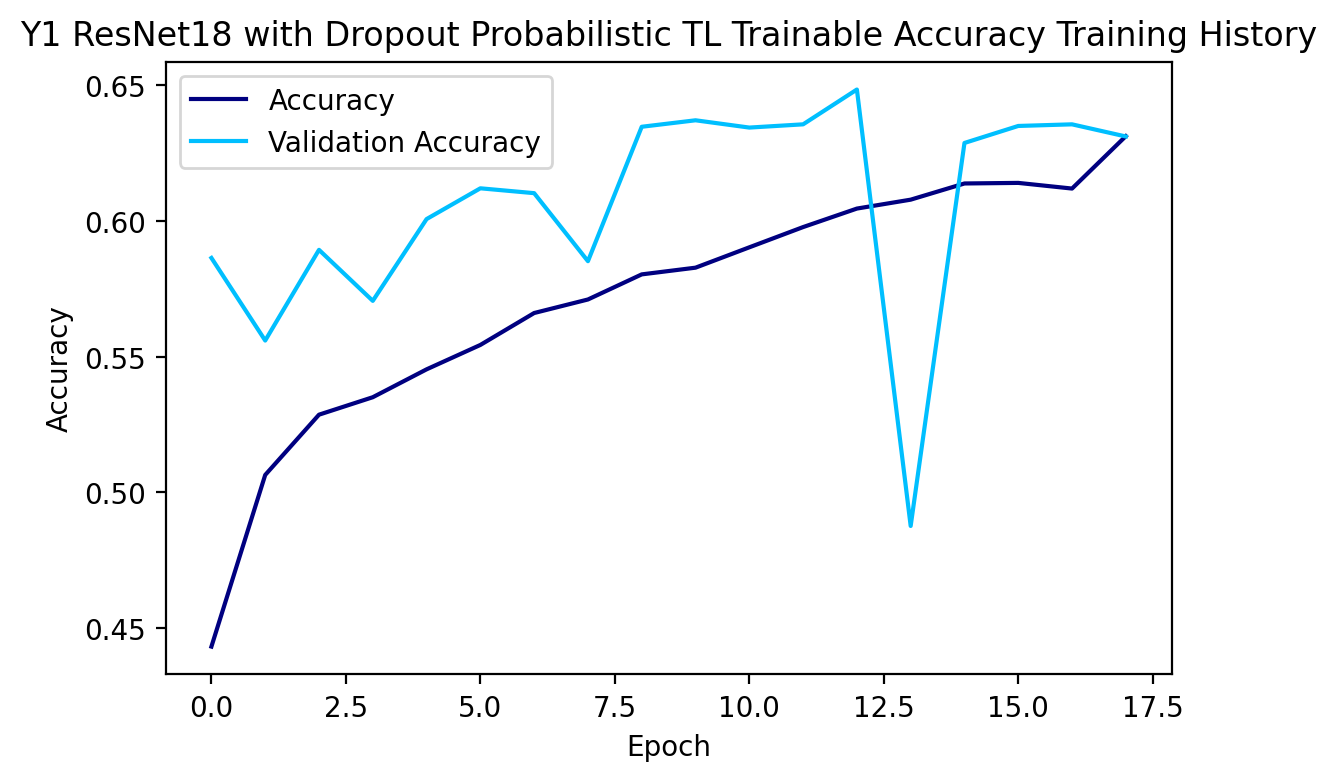

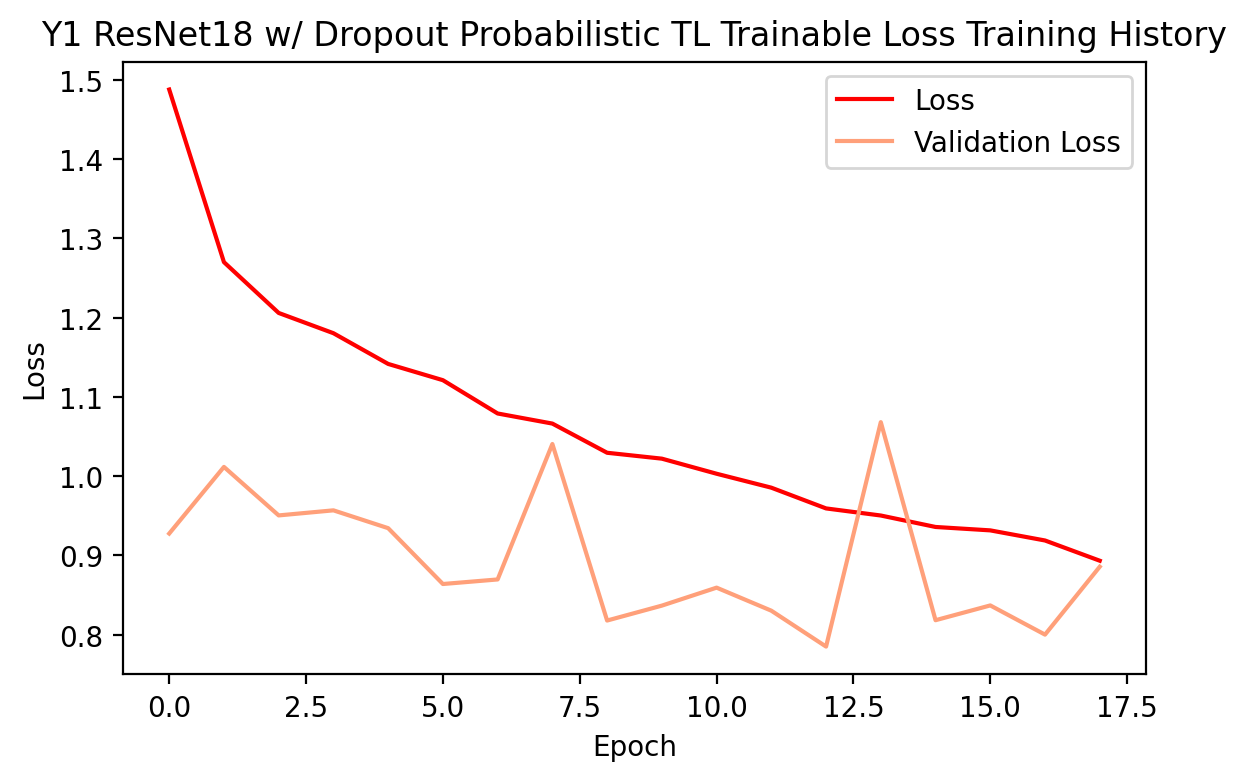

In [51]:
# Plot training history
acc = history_prob_TL_trainable['accuracy']
val_acc = history_prob_TL_trainable['val_accuracy']

loss = history_prob_TL_trainable['loss']
val_loss = history_prob_TL_trainable['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Y1 ResNet18 with Dropout Probabilistic TL Trainable Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(fname="Y1_ResNet18_Dropout_Prob_TL_Trainable_Accuracy_Training_History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Y1 ResNet18 w/ Dropout Probabilistic TL Trainable Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(fname="Y1_ResNet18_Dropout_Probabilistic_TL_Trainable_Loss_Training_History")
plt.show()

#### Method 2: Try TL and make all previous layers non-trainable

##### Setup

In [33]:
## Reload a fresh ResNet18 w/ Dropout model from the saved best trained 
# model, compile with same arguments as original
best_model = load_model("prob_resnet18_best_weights", compile=False)
best_model.summary()

# Check for trainable and non-trainable variables
print("\nSaved model has {} trainable variables: {}, ...".format(
          len(best_model.trainable_variables),
          ", ".join([v.name for v in best_model.trainable_variables])))

trainable_variable_ids = {id(v) for v in best_model.trainable_variables}
non_trainable_variables = [v for v in best_model.variables
                           if id(v) not in trainable_variable_ids]
print("\nSaved model also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables])))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 9, 106, 100)  0          ['input_2[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 2, 50, 64)    313664      ['zero_padding2d_18[0][0]']      
                                                                                            

In [34]:
# Make last layer the output, freeze previous layers, initialize new model
for layers in (best_model.layers)[:-4]:
    print(layers)
    layers.trainable = False
    
last = best_model.layers[-4].output
x = Dropout(0.5)(last)
x = GlobalAveragePooling2D(name='avgpool')(x)
outputs = Dense(units=NUM_CLASSES, activation="softmax", name='fc')(x)
base_model = Model(inputs = best_model.input, outputs = outputs)

## Compile new Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate = 1e-6)
base_model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 9, 106, 100)  0          ['input_2[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 2, 50, 64)    313664      ['zero_padding2d_18[0][0]']      
                                                                                            

##### Train

In [35]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ f" {base_model.name}"

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='prob_resnet18_TL_nontrainable_best_weights', 
                      monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir)
      ]

In [ ]:
# Re-train with Y10 data
batch_size = 16
NUM_EPOCH = 200
history_prob_TL_nontrainable = base_model.fit(X_train_10, Y_train,
                                            batch_size=batch_size,
                                            epochs=NUM_EPOCH,
                                            validation_data=(X_valid_10, Y_valid),
                                            shuffle=True,
                                            verbose=1,
                                            callbacks=es
                                            )
# Save model data
base_model.save(filepath ='Y1_ResNet18_Dropout_Probabilistic_TL_Nontrainable', 
                include_optimizer = True, 
                overwrite = True)
    
# Saving history as .npy file for future use
np.save('Y1_ResNet18_Dropout_Probabilistic_TL_Nontrainable_history.npy', 
        history_prob_TL_nontrainable.history)

Epoch 1/200
1076/1468 [====================>.........] - ETA: 27s - loss: 1.7043 - accuracy: 0.3303

In [46]:
# reload model, history if needed
# best model weights loaded into the model
base_model = load_model('prob_resnet18_TL_nontrainable_best_weights', 
                        compile=False)
history_prob_TL_nontrainable = np.load('Y1_ResNet18_Dropout_Probabilistic_TL_Nontrainable_history.npy', 
                                       allow_pickle=True).item()

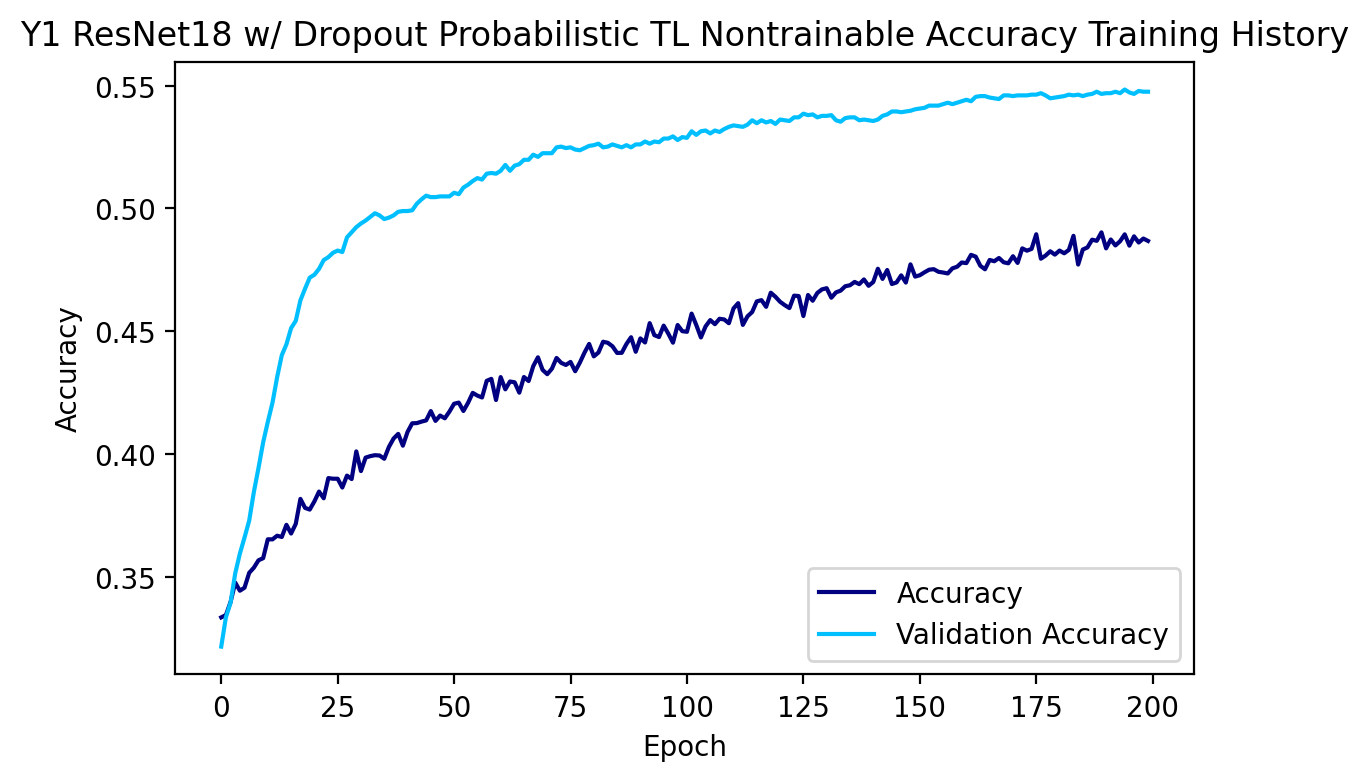

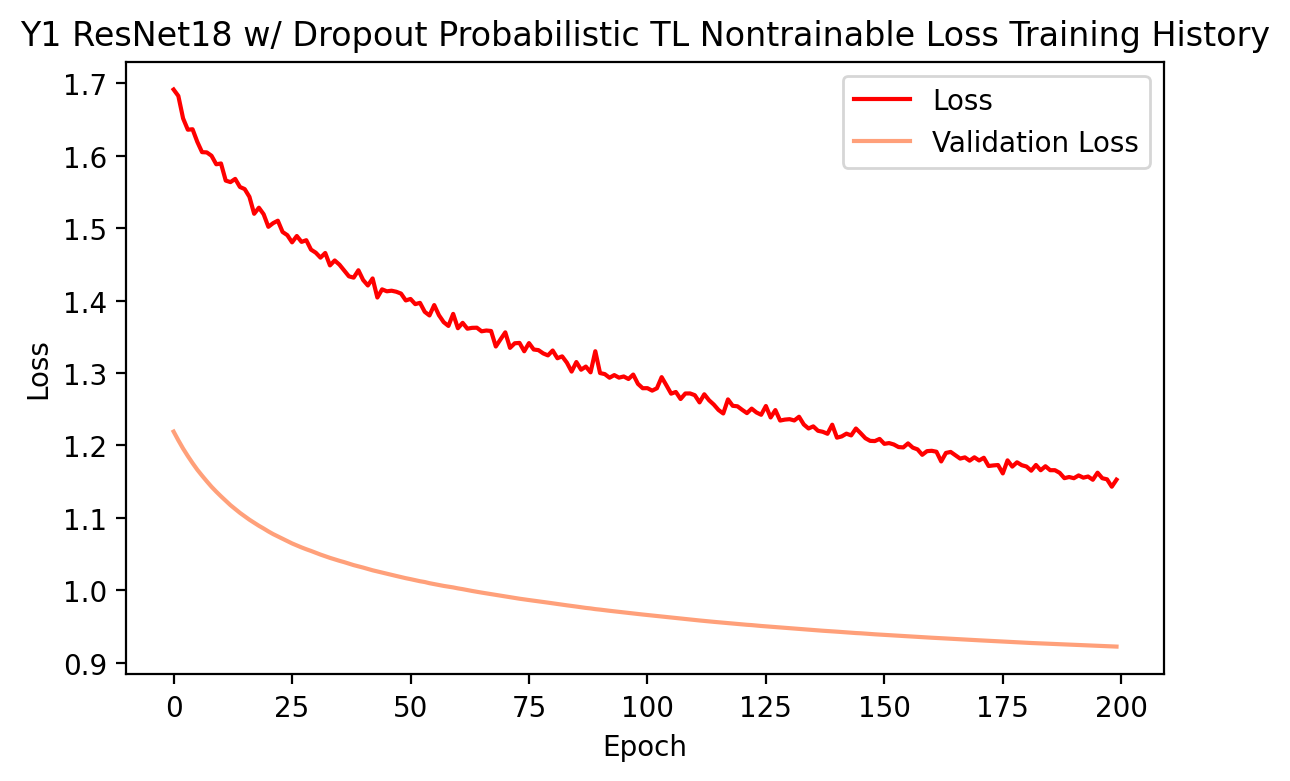

In [47]:
# Plot training history
acc = history_prob_TL_nontrainable['accuracy']
val_acc = history_prob_TL_nontrainable['val_accuracy']

loss = history_prob_TL_nontrainable['loss']
val_loss = history_prob_TL_nontrainable['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Y1 ResNet18 w/ Dropout Probabilistic TL Nontrainable Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 Dropout Probabilistic TL Nontrainable Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Y1 ResNet18 w/ Dropout Probabilistic TL Nontrainable Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 Dropout Probabilistic TL Nontrainable Loss Training History")
plt.show()

##### Evaluate on Y1 and Y10 test data

210/210 [==============================] - 7s 32ms/step
Y10 Test:
              precision    recall  f1-score   support

      Spiral       0.57      0.79      0.66      2863
  Elliptical       0.51      0.21      0.29      1631
      Merger       0.49      0.46      0.48      2221

    accuracy                           0.54      6715
   macro avg       0.52      0.49      0.48      6715
weighted avg       0.53      0.54      0.51      6715


Predictions mean:  0.7180938198064035
Predictions standard deviation:  0.9074320095507639
210/210 [==============================] - 7s 34ms/step


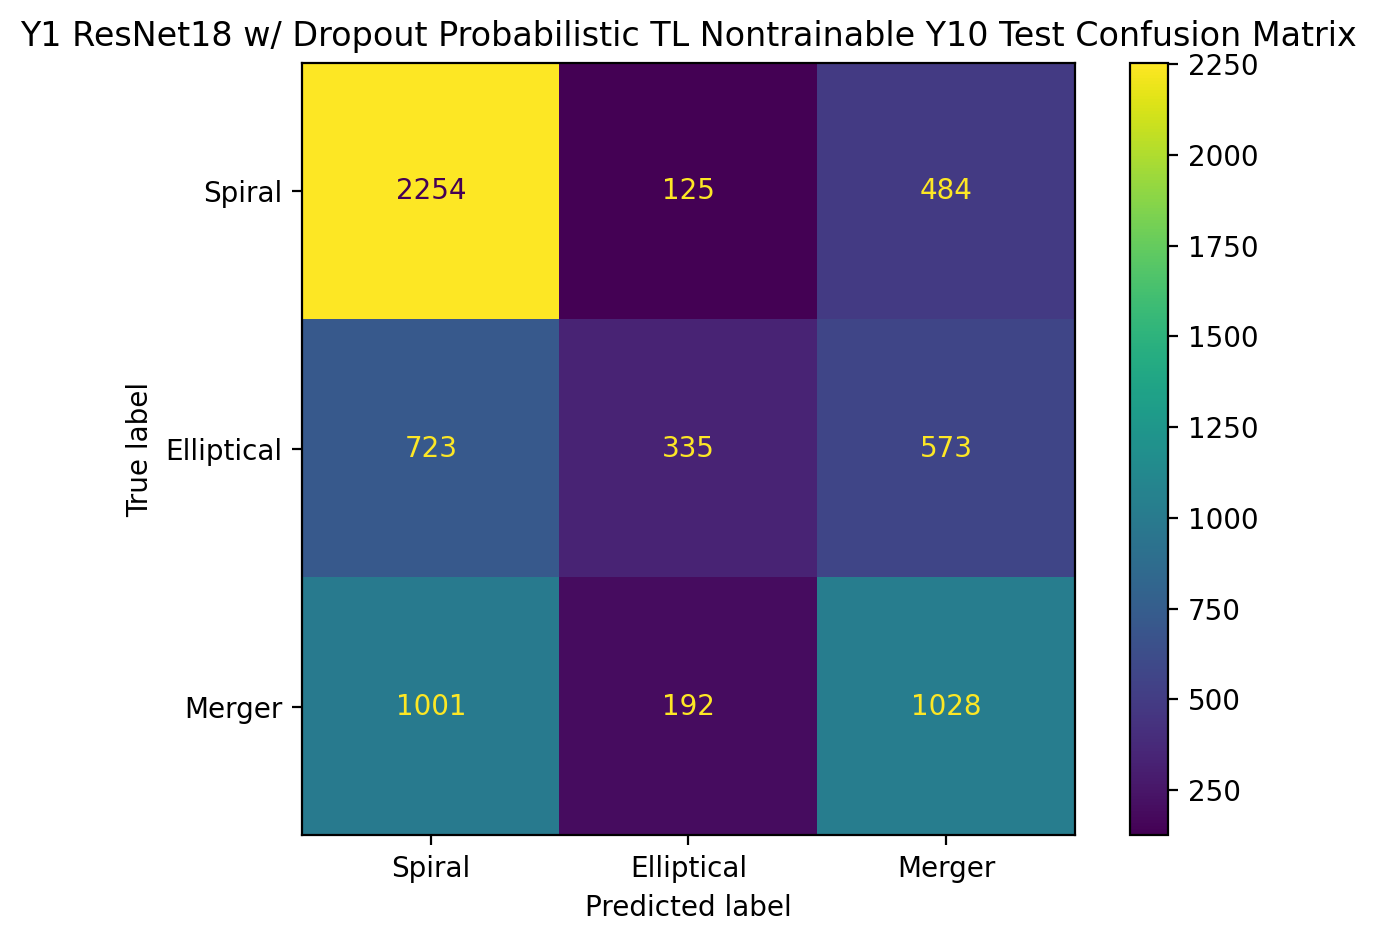

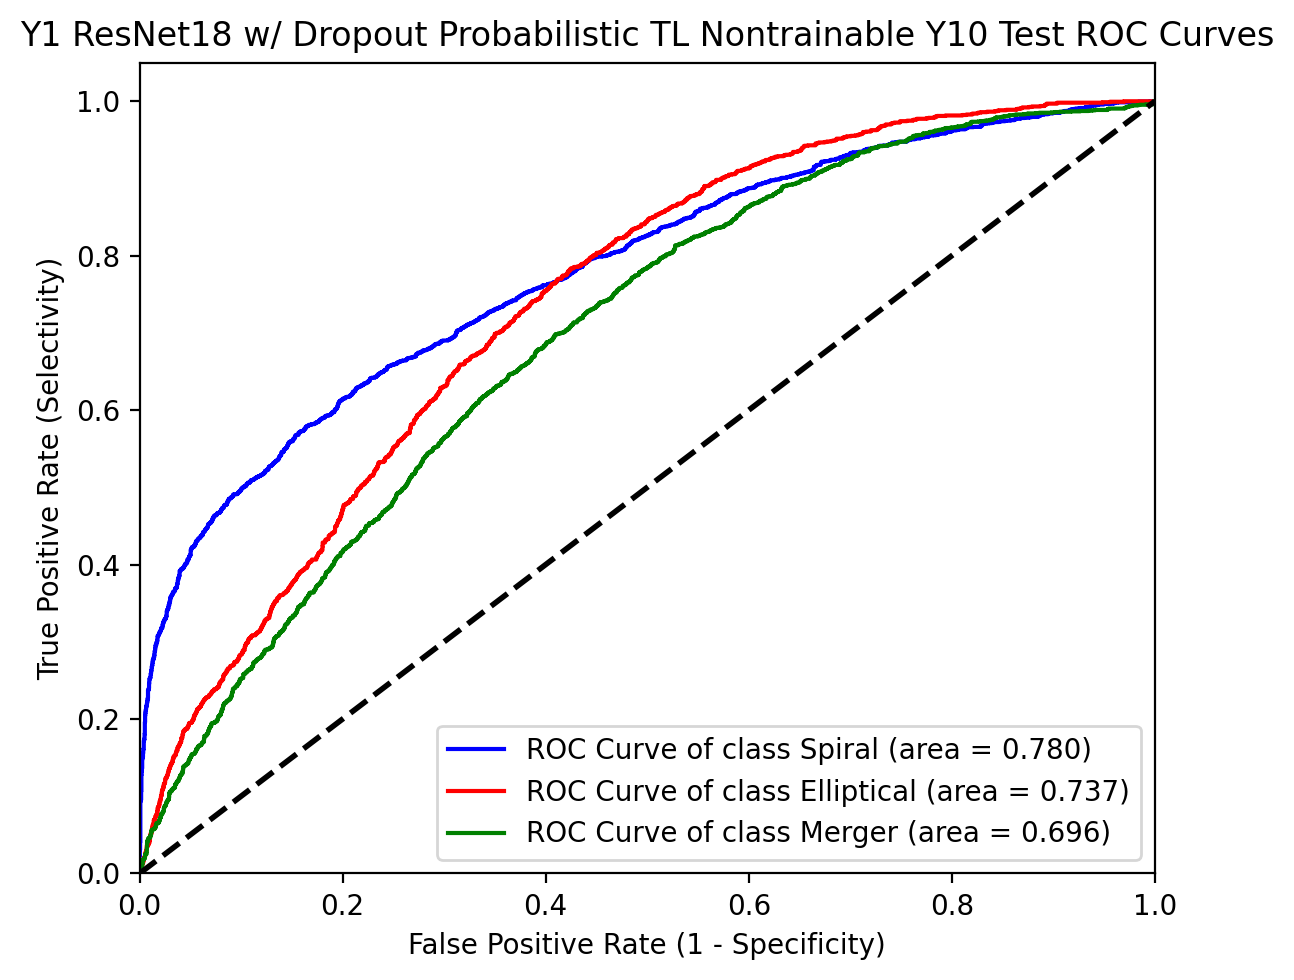

In [48]:
# Re-test model on Y10 test set 
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = base_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y10 Test:\n" + classification_metrics + '\n')

# Calculate mean and standard deviation
y_pred_mean = np.mean(np.argmax(y_pred, axis=1), axis=-1)
y_pred_std = np.std(np.argmax(y_pred, axis=1), axis=-1)

print("Predictions mean: ", y_pred_mean)
print("Predictions standard deviation: ", y_pred_std)

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(base_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 w/ Dropout Probabilistic TL Nontrainable Y10 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_Prob_TL_Nontrainable_Y10_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 w/ Dropout Probabilistic TL Nontrainable Y10 Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_Prob_TL_Nontrainable_Y10_test_ROC')
plt.show()

210/210 [==============================] - 6s 31ms/step
Y1 Test:
              precision    recall  f1-score   support

      Spiral       0.77      0.29      0.42      2863
  Elliptical       0.52      0.16      0.25      1631
      Merger       0.39      0.90      0.54      2221

    accuracy                           0.46      6715
   macro avg       0.56      0.45      0.40      6715
weighted avg       0.58      0.46      0.42      6715


Predictions mean:  1.6049143708116158
Predictions standard deviation:  0.7475786504008143
210/210 [==============================] - 7s 32ms/step


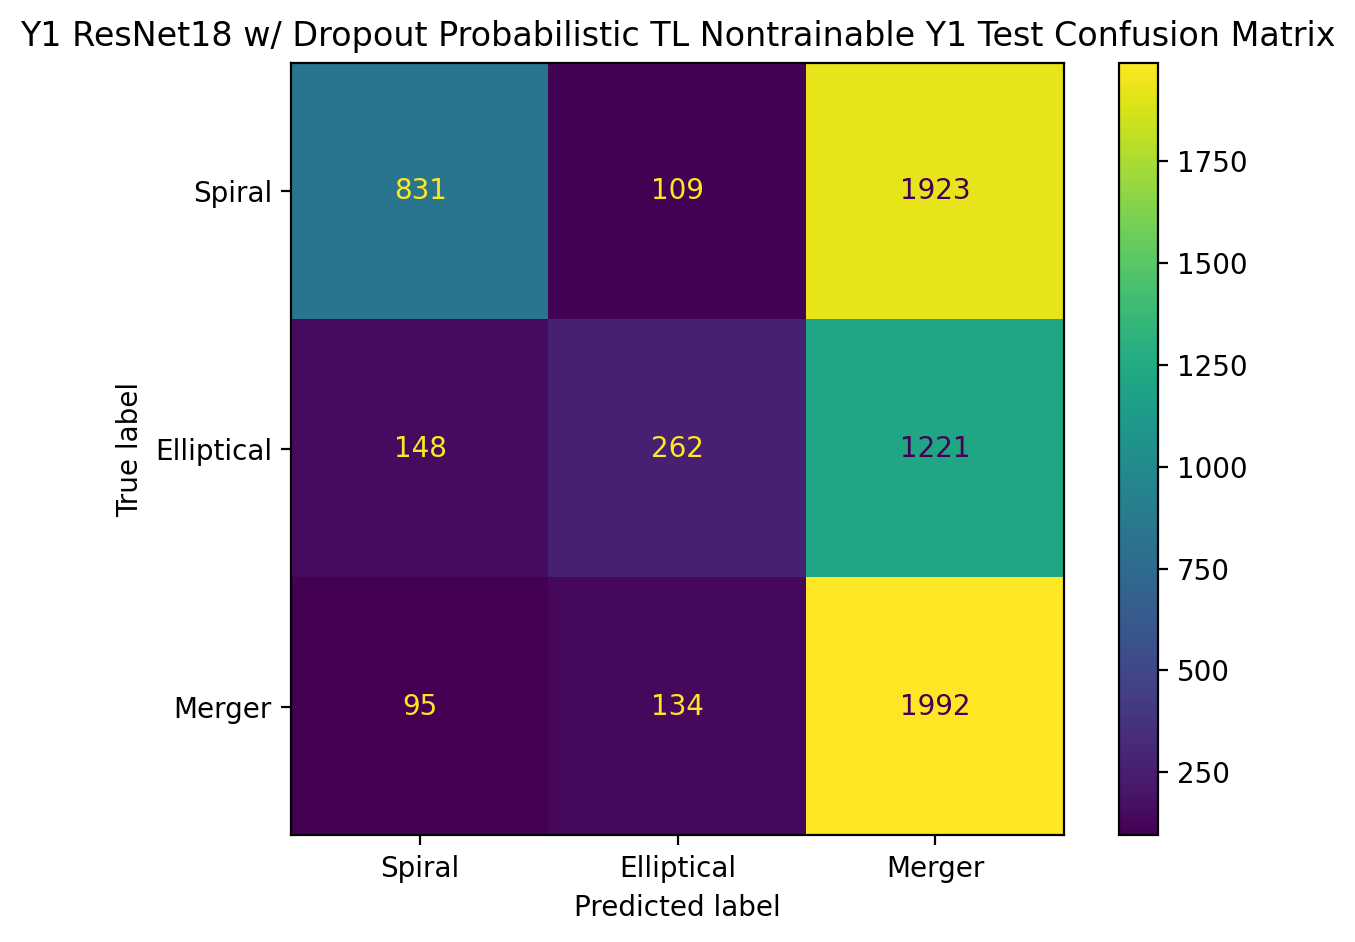

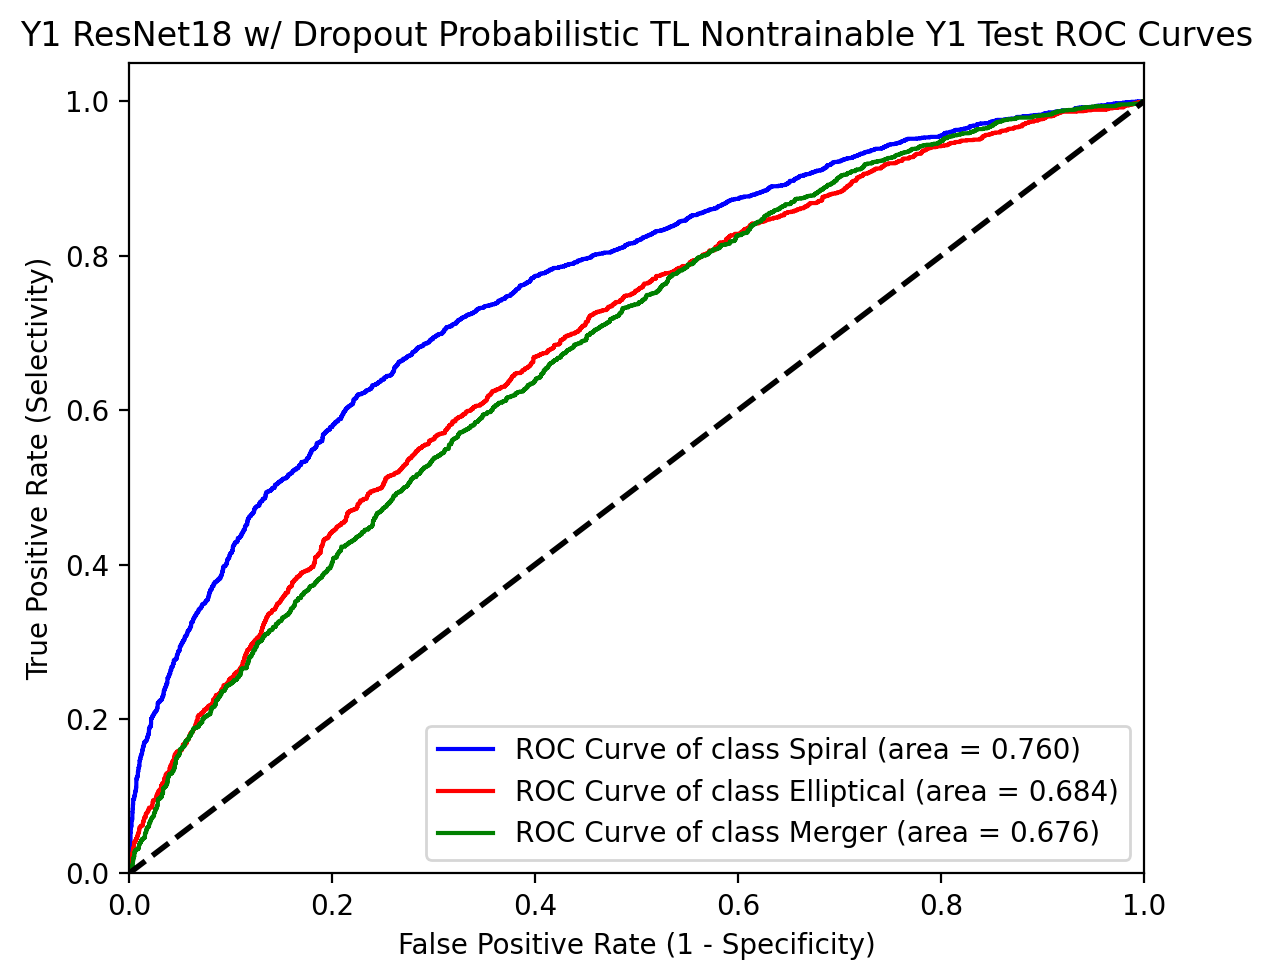

In [49]:
# Re-test model on Y1 test set 
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = base_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Calculate mean and standard deviation
y_pred_mean = np.mean(np.argmax(y_pred, axis=1), axis=-1)
y_pred_std = np.std(np.argmax(y_pred, axis=1), axis=-1)

print("Predictions mean: ", y_pred_mean)
print("Predictions standard deviation: ", y_pred_std)

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(base_model.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 w/ Dropout Probabilistic TL Nontrainable Y1 Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_Prob_TL_Nontrainable_Y1_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 w/ Dropout Probabilistic TL Nontrainable Y1 Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_Prob_TL_Nontrainable_Y1_test_ROC')
plt.show()

## Bayesian Neural Network

#### Setup

In [11]:
# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn
kl_divergence_function = lambda q, p, _: tfd.kl_divergence(q, p) / X_train_1.shape[0]

In [12]:
# ResNet18 w/ Dropout
def conv3x3_bnn(x, out_planes, stride=1, name=None):
    x = ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return tfp.layers.Convolution2DReparameterization(filters=out_planes,
                                                        kernel_size=3, 
                                                        strides=stride, 
                                                        kernel_divergence_fn=kl_divergence_function, 
                                                        name=name)(x)

def basic_block_bnn(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3_bnn(x, planes, stride=stride, name=f'{name}.conv1')
    out = BatchNormalization(name=f'{name}.bn1')(out)
    out = Activation('relu', name=f'{name}.relu1')(out)

    out = conv3x3_bnn(out, planes, name=f'{name}.conv2')
    out = BatchNormalization(name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = Add(name=f'{name}.add')([identity, out])
    out = Activation('relu', name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [tfp.layers.Convolution2DReparameterization(filters=planes, 
                                                                kernel_size=1,
                                                                strides=stride, 
                                                                kernel_divergence_fn = kl_divergence_function,
                                                                name=f'{name}.0.downsample.0'),
                      BatchNormalization(name=f'{name}.0.downsample.1')
                      ]

    x = basic_block_bnn(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block_bnn(x, planes, name=f'{name}.{i}')

    return x

def resnet_bnn(x, blocks_per_layer, num_classes=NUM_CLASSES):
    x = ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = tfp.layers.Convolution2DReparameterization(filters=64, 
                                                    kernel_size=7,
                                                    strides=2, name='conv1', 
                                                    kernel_divergence_fn = kl_divergence_function)(x)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D(name='avgpool')(x)
    # Create hidden layers with weight uncertainty using the DenseFlipout layer
    # Produces the parameters of the distribution
    distribution_params = tfp.layers.DenseReparameterization(units=num_classes,
                                                              activation="relu",
                                                              kernel_divergence_fn=kl_divergence_function,
                                                              name='fc')(x)
    # Output is a distribution object (OneHotCategorical), used for multiple classes
    outputs = tfp.layers.OneHotCategorical(num_classes)(distribution_params)

    return outputs

def resnet18_bnn(x, **kwargs):
    return resnet_bnn(x, [2, 2, 2, 2], **kwargs)

In [35]:
def model_builder(hp):
    # Initialize Bayesian model for 3 classes
    inputs = Input(shape = (3, 100, 100))
    outputs = resnet18_bnn(inputs)
    model = Model(inputs, outputs)

    ## Compile Model
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[1e-2, 1e-3, 1e-4, 
                                         1e-5, 1e-6, 1e-7])
    optimizer = Adam(lr=hp_learning_rate)
    ## Compile Model
    model.compile(optimizer=optimizer, loss=nll, metrics=['accuracy'])
    model.summary()
    return model

# instantiate the Hyperband tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     seed=0,
                     max_epochs=200)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [37]:
batch_size = 16

# Run the hyperparameter search
tuner.search(X_train_1, Y_train, 
             batch_size = batch_size,             
             validation_data = (X_valid_1, Y_valid),
             shuffle = True,
             class_weight = class_weights,
             verbose = 1,
             callbacks = es
            )

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [38]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]

print(f"""
The hyperparameter search is complete. The optimal 
learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal 
learning rate for the optimizer is 1e-06.



In [ ]:
# Find optimal number of epochs to train model with 
# hyperparameters obtained from search

# Build model with optimal hyperparameters, train for 200 epochs
bayesian_resnet18_model = tuner.hypermodel.build(best_hps)

batch_size = 16
NUM_EPOCH = 200
history_BNN = bayesian_resnet18_model.fit(X_train_1, Y_train,
                                        batch_size = batch_size,
                                        epochs = NUM_EPOCH,              
                                        validation_data = (X_valid_1, Y_valid),
                                        shuffle = True,
                                        class_weight = class_weights,
                                        verbose = 1,
                                        callbacks = es
                                        )

val_acc_per_epoch = history_BNN.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#### Train

In [14]:
## Define Callback Functions
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f" {bayesian_resnet18_model.name}"

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5), 
      ModelCheckpoint(filepath='bnn_resnet18_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tf.keras.callbacks.TensorBoard(log_dir=log_dir),
      ]

In [15]:
# To help memory usage
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [16]:
# Re-instantiate BNN hypermodel, train with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)

# re-train model
batch_size = 16
history_resnet18_BNN = hypermodel.fit(X_train_1, Y_train,
                            batch_size = batch_size,
                            epochs = best_epoch,              
                            validation_data = (X_valid_1, Y_valid),
                            shuffle = True,
                            class_weight = class_weights,
                            verbose = 1,
                            callbacks = es
                            )

# Save bayesian model data
hypermodel.save(filepath = f'Y1_ResNet18_Dropout_BNN', 
                include_optimizer = True, 
                overwrite = True)

# Saving history as .npy file for future use
np.save(f'Y1_ResNet18_Dropout_BNN_history.npy', 
        history_resnet18_BNN.history)

Epoch 1/200


2023-04-12 16:12:19.152213: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-12 16:12:19.693752: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


92/92 [==============================] - ETA: 0s - loss: 1216.6218 - accuracy: 0.3340
Epoch 1: val_accuracy improved from -inf to 0.34188, saving model to bnn_resnet18_best_weights


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 74s 739ms/step - loss: 1216.6218 - accuracy: 0.3340 - val_loss: 1195.0692 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 2/200
92/92 [==============================] - ETA: 0s - loss: 1174.1226 - accuracy: 0.3332
Epoch 2: val_accuracy did not improve from 0.34188
92/92 [==============================] - 42s 456ms/step - loss: 1174.1226 - accuracy: 0.3332 - val_loss: 1152.6251 - val_accuracy: 0.3306 - lr: 0.0010
Epoch 3/200
92/92 [==============================] - ETA: 0s - loss: 1131.7411 - accuracy: 0.3345
Epoch 3: val_accuracy did not improve from 0.34188
92/92 [==============================] - 41s 444ms/step - loss: 1131.7411 - accuracy: 0.3345 - val_loss: 1110.2949 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 4/200
92/92 [==============================] - ETA: 0s - loss: 1089.4565 - accuracy: 0.3374
Epoch 4: val_accuracy did not improve from 0.34188
92/92 [==============================] - 42s 452ms/step - loss: 1089.4565 - accuracy: 0.3374 - val_l

INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 64s 695ms/step - loss: 57.8026 - accuracy: 0.3379 - val_loss: 53.0500 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 39/200
92/92 [==============================] - ETA: 0s - loss: 48.8295 - accuracy: 0.3366
Epoch 39: val_accuracy did not improve from 0.34575
92/92 [==============================] - 40s 440ms/step - loss: 48.8295 - accuracy: 0.3366 - val_loss: 44.6925 - val_accuracy: 0.3365 - lr: 0.0010
Epoch 40/200
92/92 [==============================] - ETA: 0s - loss: 41.0322 - accuracy: 0.3317
Epoch 40: val_accuracy did not improve from 0.34575
92/92 [==============================] - 41s 443ms/step - loss: 41.0322 - accuracy: 0.3317 - val_loss: 37.4528 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 41/200
92/92 [==============================] - ETA: 0s - loss: 34.3241 - accuracy: 0.3341
Epoch 41: val_accuracy did not improve from 0.34575
92/92 [==============================] - 40s 434ms/step - loss: 34.3241 - accuracy: 0.3341 - val_loss: 31.2831 -

INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 62s 672ms/step - loss: 2.7897 - accuracy: 0.3315 - val_loss: 2.7441 - val_accuracy: 0.3463 - lr: 0.0010
Epoch 66/200
92/92 [==============================] - ETA: 0s - loss: 2.7005 - accuracy: 0.3326
Epoch 66: val_accuracy did not improve from 0.34635
92/92 [==============================] - 42s 452ms/step - loss: 2.7005 - accuracy: 0.3326 - val_loss: 2.6566 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 67/200
92/92 [==============================] - ETA: 0s - loss: 2.6333 - accuracy: 0.3286
Epoch 67: val_accuracy did not improve from 0.34635
92/92 [==============================] - 44s 475ms/step - loss: 2.6333 - accuracy: 0.3286 - val_loss: 2.5960 - val_accuracy: 0.3174 - lr: 0.0010
Epoch 68/200
92/92 [==============================] - ETA: 0s - loss: 2.5578 - accuracy: 0.3305
Epoch 68: val_accuracy did not improve from 0.34635
92/92 [==============================] - 41s 447ms/step - loss: 2.5578 - accuracy: 0.3305 - val_loss: 2.5199 - val_accura

INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: bnn_resnet18_best_weights/assets


92/92 [==============================] - 63s 689ms/step - loss: 1.9113 - accuracy: 0.3292 - val_loss: 1.9041 - val_accuracy: 0.3541 - lr: 0.0010
Epoch 82/200
92/92 [==============================] - ETA: 0s - loss: 1.8847 - accuracy: 0.3329
Epoch 82: val_accuracy did not improve from 0.35410
92/92 [==============================] - 40s 437ms/step - loss: 1.8847 - accuracy: 0.3329 - val_loss: 1.8634 - val_accuracy: 0.3383 - lr: 0.0010
Epoch 83/200
92/92 [==============================] - ETA: 0s - loss: 1.8463 - accuracy: 0.3298
Epoch 83: val_accuracy did not improve from 0.35410
92/92 [==============================] - 42s 461ms/step - loss: 1.8463 - accuracy: 0.3298 - val_loss: 1.8301 - val_accuracy: 0.3308 - lr: 0.0010
Epoch 84/200
92/92 [==============================] - ETA: 0s - loss: 1.8170 - accuracy: 0.3344
Epoch 84: val_accuracy did not improve from 0.35410
92/92 [==============================] - 42s 452ms/step - loss: 1.8170 - accuracy: 0.3344 - val_loss: 1.8122 - val_accura

INFO:tensorflow:Assets written to: Y1_ResNet18_Dropout_BNN/assets


INFO:tensorflow:Assets written to: Y1_ResNet18_Dropout_BNN/assets


In [ ]:
%tensorboard --logdir logs/fit

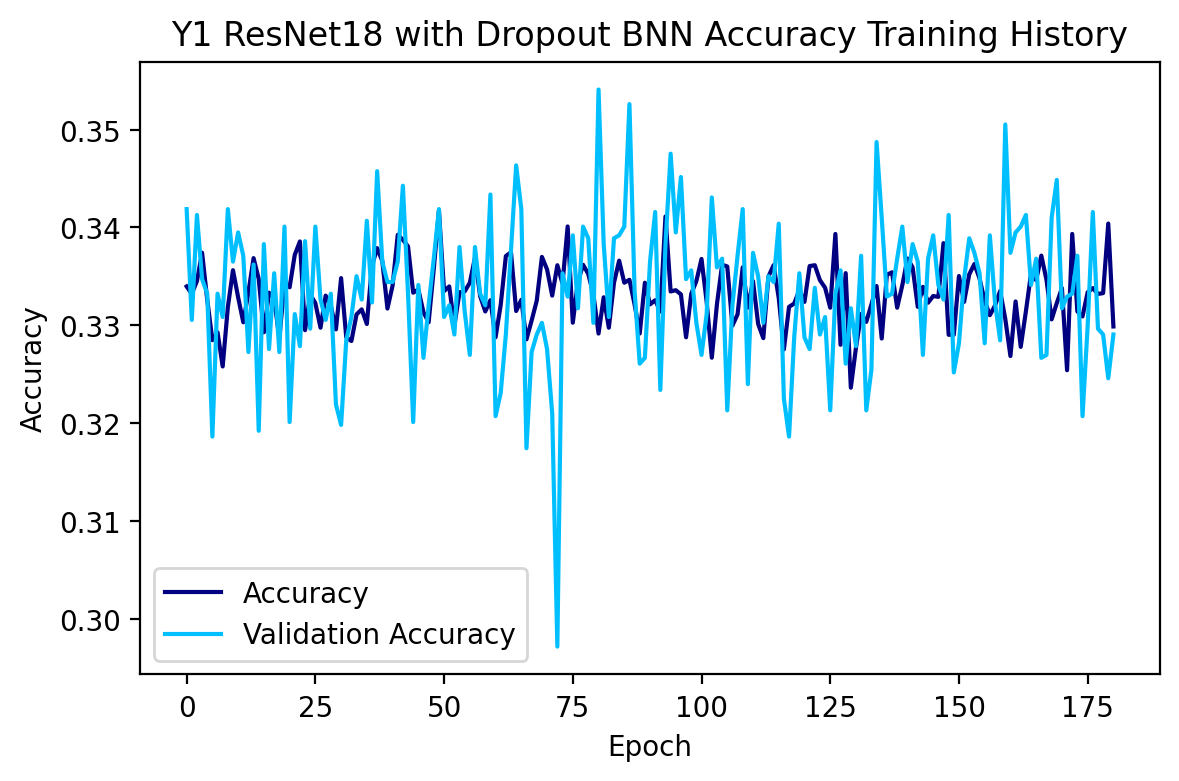

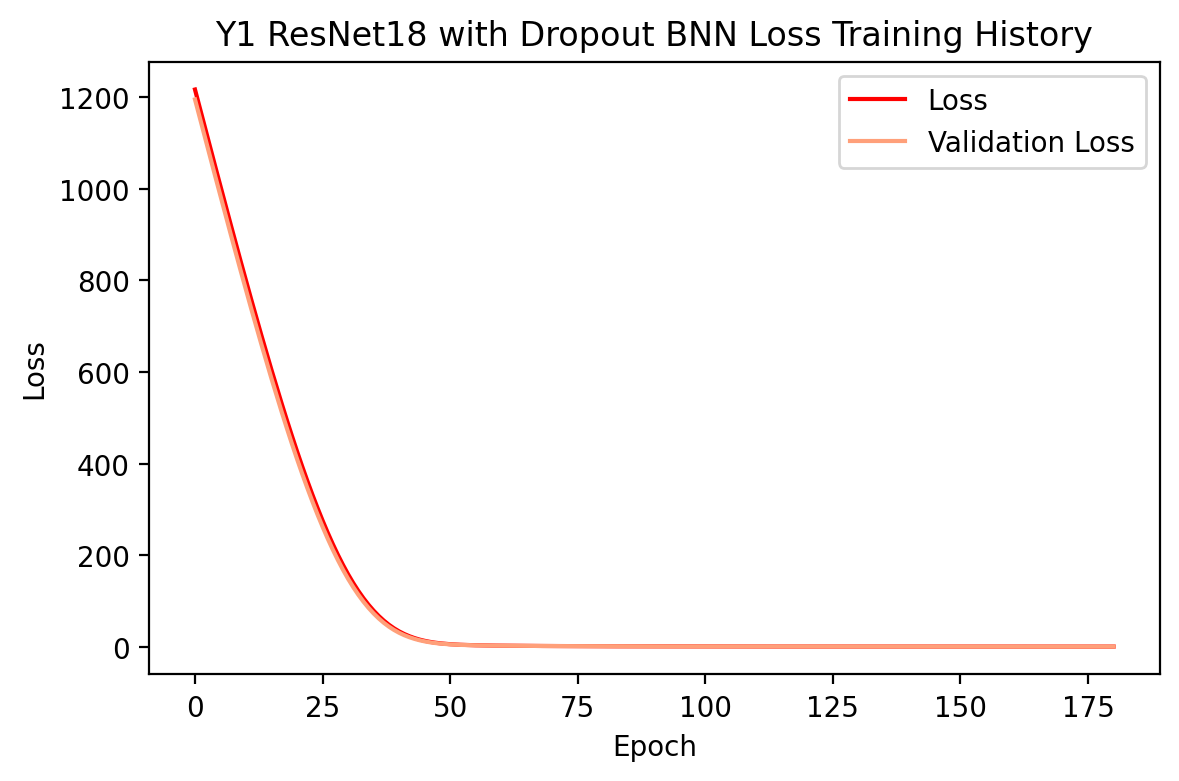

In [18]:
#history_resnet18_BNN = np.load('Y1_ResNet18_Dropout_', allow_pickle=True).item()

# Plot bayesian model training history
acc = history_resnet18_BNN.history['accuracy']
val_acc = history_resnet18_BNN.history['val_accuracy']

loss = history_resnet18_BNN.history['loss']
val_loss = history_resnet18_BNN.history['val_loss']
epochs = list(range(len(loss)))

# Plot accuracy
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, acc, 'navy', label='Accuracy')
plt.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Y1 ResNet18 with Dropout BNN Accuracy Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout BNN Accuracy Training History")
plt.show()

# Plot loss
figsize=(6, 4)
figure = plt.figure(figsize=figsize)
plt.plot(epochs, loss, 'red', label='Loss')
plt.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Y1 ResNet18 with Dropout BNN Loss Training History")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("Y1 ResNet18 with Dropout BNN Loss Training History")
plt.show()

#### Evaluate on Y1 and Y10 test data

In [40]:
# reload model, history if needed
# best model weights loaded into the model
bnn_model = load_model('Y1_ResNet18_Dropout_BNN', compile=False)
bnn_model.load_weights('bnn_resnet18_best_weights')

2023-04-14 18:43:16.903909: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open bnn_resnet18_best_weights: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


210/210 [==============================] - 9s 38ms/step
Y1 Test:
              precision    recall  f1-score   support

      Spiral       0.42      0.33      0.37      2863
  Elliptical       0.24      0.32      0.28      1631
      Merger       0.33      0.34      0.34      2221

    accuracy                           0.33      6715
   macro avg       0.33      0.33      0.33      6715
weighted avg       0.35      0.33      0.34      6715


210/210 [==============================] - 8s 37ms/step


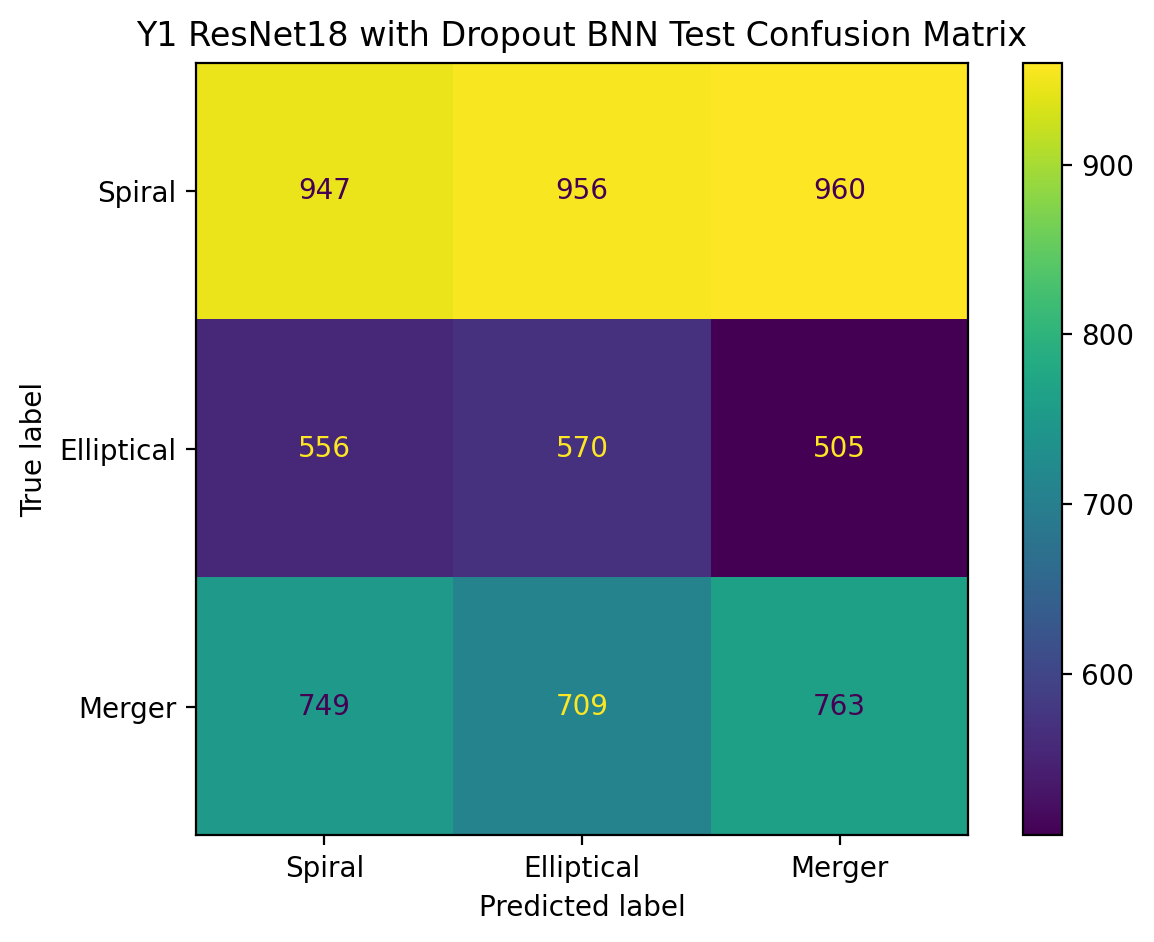

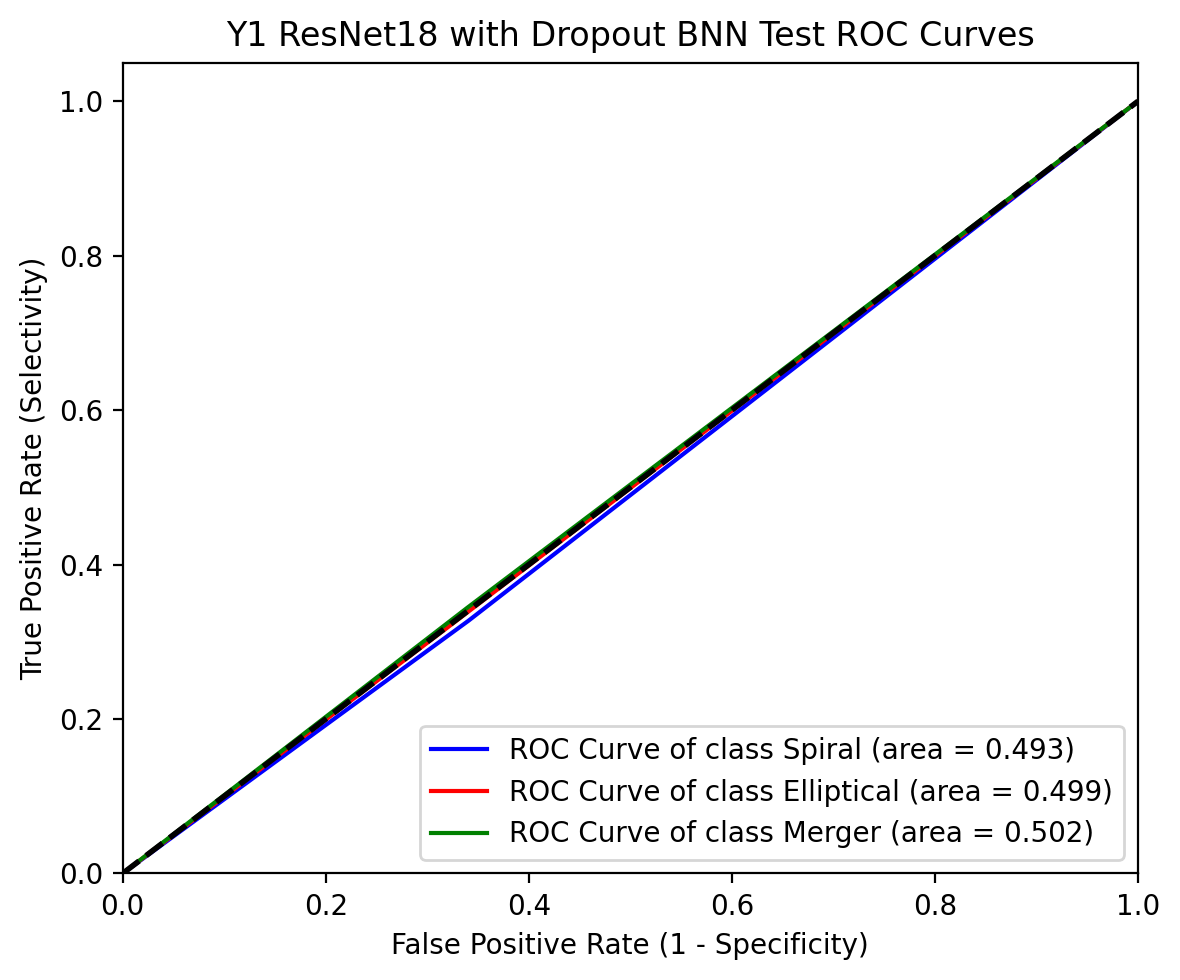

In [41]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = bnn_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Y1 Test:\n" + classification_metrics + '\n')

# Calculate mean and standard deviation
y_pred_mean = np.round(np.mean(np.argmax(y_pred, axis=1), axis=-1), 3)
y_pred_std = np.round(np.std(np.argmax(y_pred, axis=1), axis=-1), 3)

print("Predictions mean: ", y_pred_mean)
print("Predictions standard deviation: ", y_pred_std)
# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(bnn_model.predict(X_test_1), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y1 ResNet18 with Dropout BNN Test Confusion Matrix')
plt.tight_layout()
plt.savefig('Y1_ResNet18_Dropout_BNN_test_CM')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y1 ResNet18 with Dropout BNN Test ROC Curves')
plt.savefig('Y1_ResNet18_Dropout_BNN_test_ROC')
plt.show()

#### Analyze BNN Model Predictions and Outputs

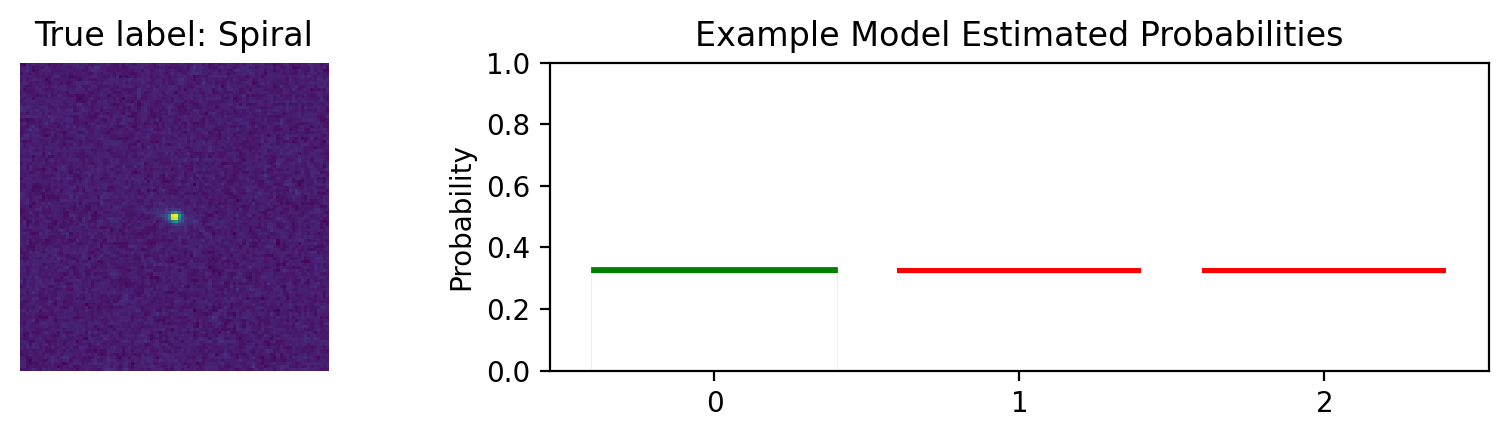

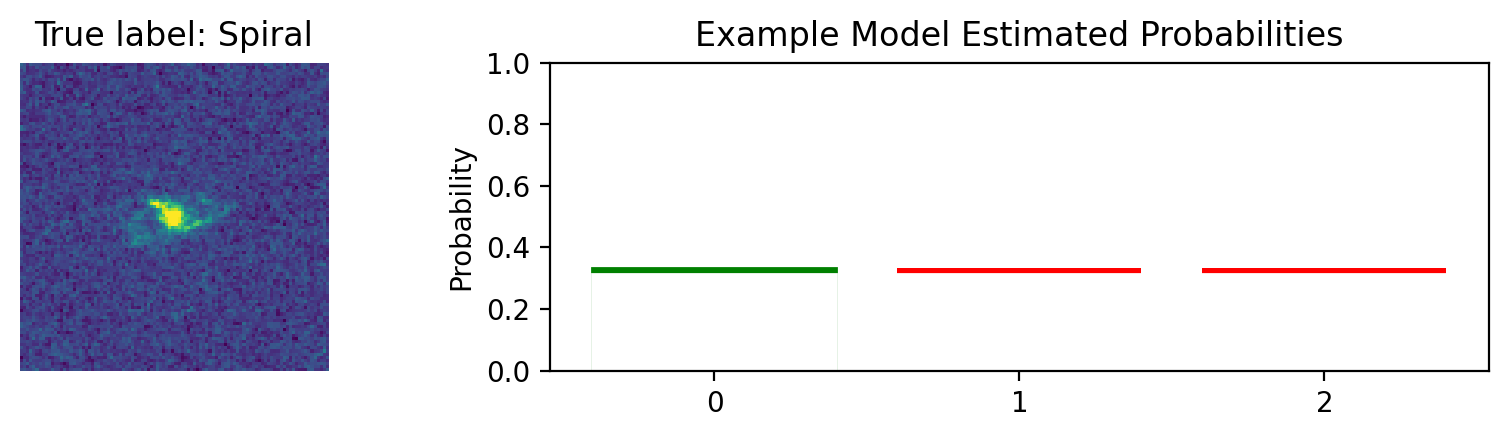

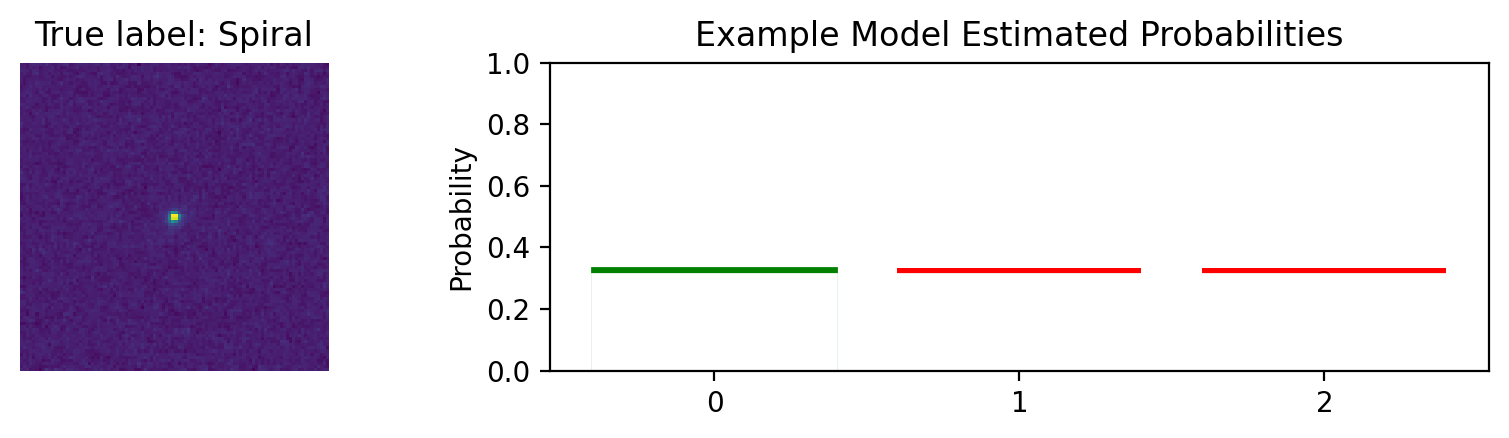

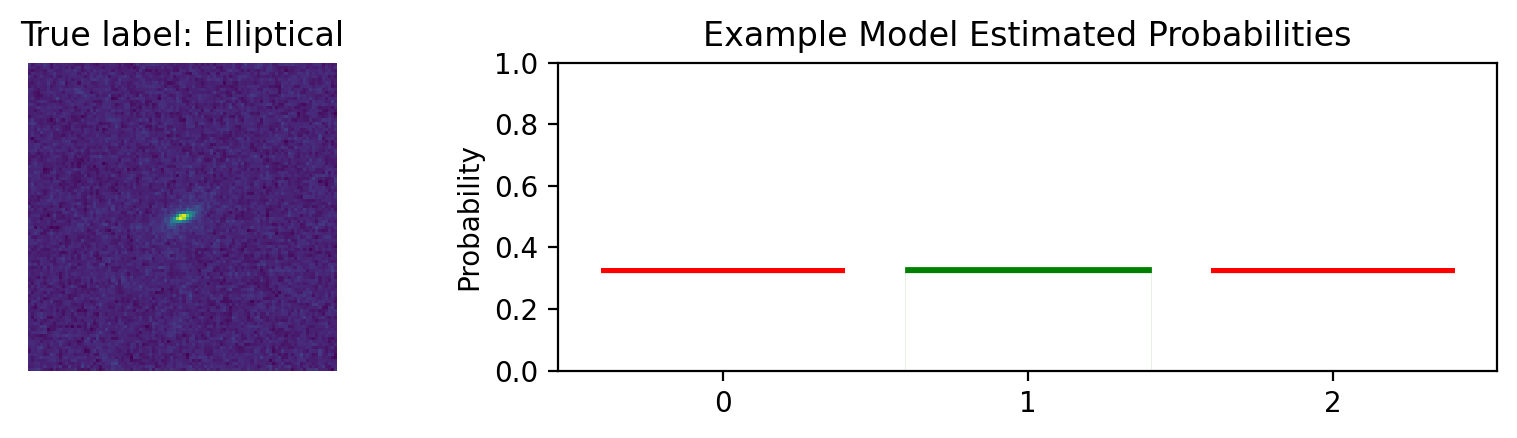

KeyboardInterrupt: 

In [90]:
# Evaluate and visualize for Y1 test data
for i in examples:
    analyse_model_prediction(X_test_1, Y_test, bayesian_resnet18_model, i, run_ensemble=True)

In [ ]:
# Evaluate and visualize for Y10 test data
for i in examples:
    analyse_model_prediction(X_test_10, Y_test, bayesian_resnet18_model, i, run_ensemble=True)